# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import getpass
import math

In [3]:
import sqlalchemy
from sqlalchemy.pool import NullPool

In [4]:
from datetime import datetime, date, timedelta

In [5]:
import matplotlib.pyplot as plt

In [6]:
import pandas as pd # if there is a DeprecationWarning about Pyarrow, we can ignore it
import numpy as np

In [7]:
# https://pypi.org/project/tqdm/
from tqdm import tqdm # progress bar wrapper, will be used below

In [8]:
import statsmodels.api as sm

In [9]:
from PyEMD import EMD

In [10]:
from scipy import stats

In [11]:
from sklearn.metrics import mean_squared_error

# Custom Functions

## Data Preparation

In [12]:
def load_data(data_source, username, password=None):
    if password == None:
        pass
    else:
        db_engine = sqlalchemy.create_engine(
                f'postgresql://{username}:{password}', 
                connect_args={'sslmode':'require'}, poolclass=NullPool)

    items_w_products_df = pd.read_sql(f'''
        SELECT *
        FROM {data_source}
        ''' , db_engine)

    db_engine.dispose()
    
    return items_w_products_df

In [13]:
def prepare_data_by_product_group(data, product_group, product_group_name='productGroup1'):
    prepared_data = data.loc[data[product_group_name] == product_group].copy().reset_index(drop=True)
   
    prepared_data_per_day = prepared_data.groupby(prepared_data.orderDate).agg({'orderQuantity': 'sum'})
    prepared_data_per_day = prepared_data_per_day.loc[date(2010,1,1):].copy() 
    prepared_data_per_day = prepared_data_per_day.asfreq(freq='1D', fill_value=0)
    prepared_data_per_day.index = pd.DatetimeIndex(prepared_data_per_day.index, freq='D')
    prepared_data_per_day.sort_index(inplace=True)
    prepared_data_per_day.index.rename('ds', inplace=True)
    
    prepared_data_per_day.rename(columns={'orderQuantity': 'y'}, inplace=True)
   
    return prepared_data_per_day

In [14]:
def plot_product_groups(prod_group_data, plot_cols=4, figsize=(30,20)):
    num_cols = plot_cols
    num_rows = math.ceil(len(prod_group_data) / num_cols)

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=.5)

    counter = 1
    for prod_group, data in prod_group_data.items():
        plt.subplot(num_rows, num_cols, counter)
        plt.plot(data)
        plt.gca().set_title(prod_group)
        counter += 1

    plt.show()

## SSA

In [15]:
# source: https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook#3.-Time-Series-Component-Separation-and-Grouping

class SSA(object):
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array, or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if a NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        # if not isinstance(tseries, self.__supported_types):
        #    raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array, or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N / 2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Check if the length of the time series is less than the window length
        if self.N < self.L:
            raise ValueError("The length of the time series is less than the window length.")

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L + i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix using SVD
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([self.Sigma[i] * np.outer(self.U[:, i], VT[i, :]) for i in range(self.d)])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:, i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0] + 1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i] * np.outer(self.U[:, i], VT[i, :])
                X_rev = X_elem[::-1]
                self.TS_comps[:, i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0] + 1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

# Load Data

## ATU

In [16]:
items_w_products_atu = load_data(data_source='atu.order_items_w_products_20220727', username, password=getpass.getpass())

 ········


In [17]:
items_w_products_atu['orderDate'] = items_w_products_atu.orderDate.apply(lambda x: x.date())

In [18]:
items_w_products_atu = items_w_products_atu.loc[items_w_products_atu['orderDate'] > date(2010,1,1)]

In [19]:
grouped_by_atu = items_w_products_atu.groupby(items_w_products_atu.productGroup1).agg({'orderQuantity': 'sum'}).sort_values(by='orderQuantity', ascending=False)
product_groups_atu = grouped_by_atu.index.tolist()[:20]

In [20]:
prod_group_data_atu = {}
for product_group in product_groups_atu:
    prod_group_data_atu[product_group] = prepare_data_by_product_group(items_w_products_atu, product_group)

In [21]:
prod_group_data_atu.keys()

dict_keys(['Reifen', 'X_Reifenservice', 'Reifen-Montage', 'Motoröle', 'Sonstiges', 'Zubehör', 'Zum Shop', 'Altreifenentsorgung', 'Wischblätter', 'Kompletträder Winter', 'Kompletträder Stahl', 'Ersatzteile', 'Zündkerzen', 'Autokindersitze', 'Xenon', 'Spende', 'Ölfilter', 'Linsen und Träger', 'Ölwechsel', 'Kompletträder Sommer'])

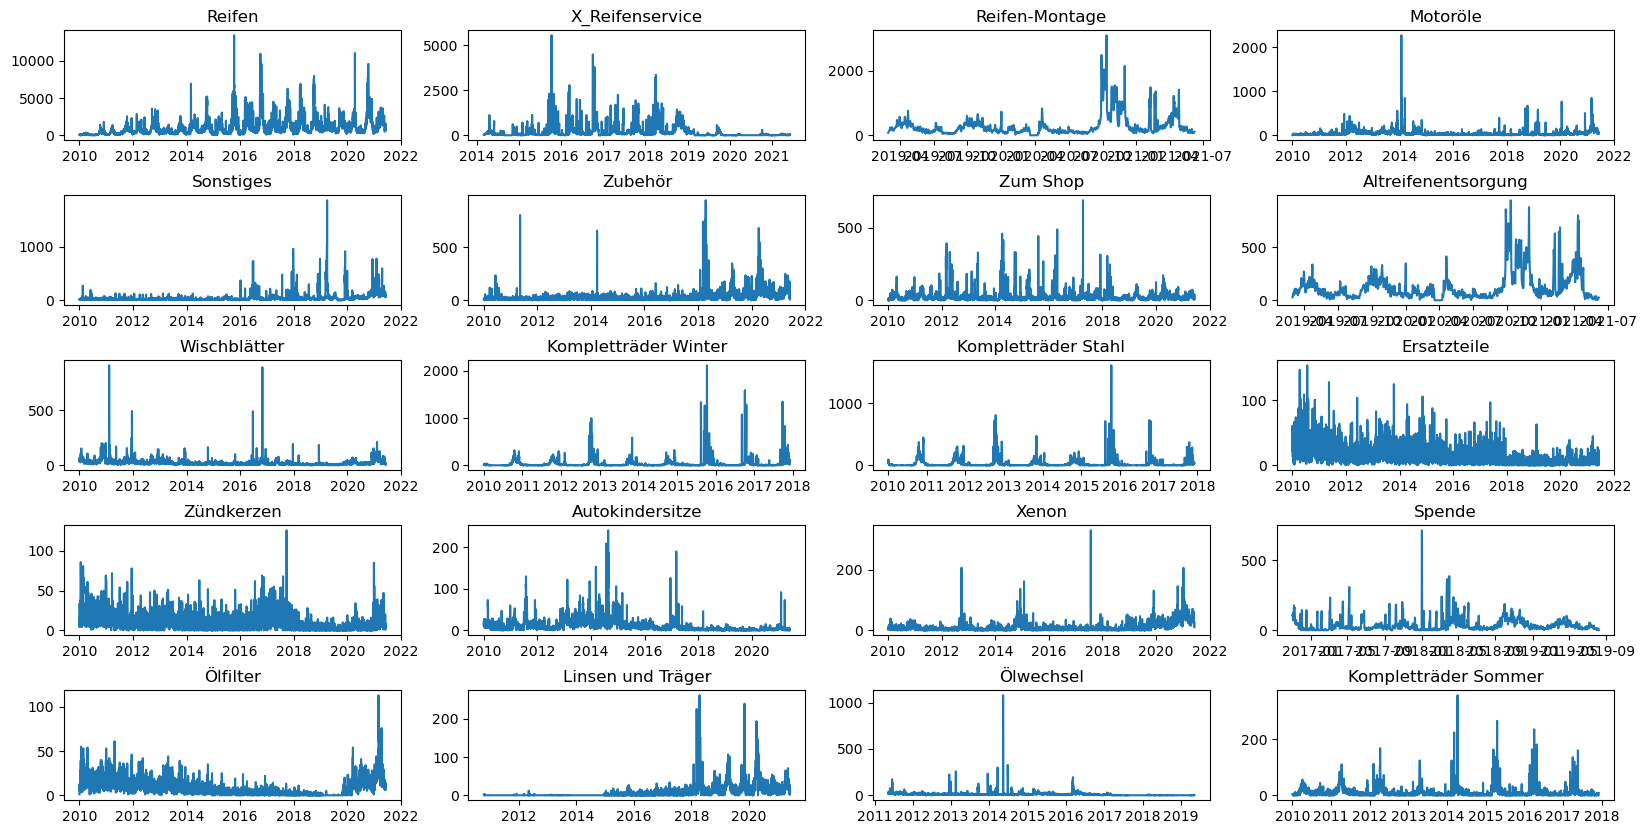

In [22]:
plot_product_groups(prod_group_data=prod_group_data_atu, plot_cols=4, figsize=(20,10))

## Lott

In [23]:
items_w_products_lott = load_data(data_source='lott.order_items_w_products_20220429', username, password=getpass.getpass())

 ········


In [24]:
items_w_products_lott['orderDate'] = items_w_products_lott.orderDate.apply(lambda x: x.date())

In [25]:
items_w_products_lott = items_w_products_lott.loc[items_w_products_lott['orderDate'] > date(2016,1,1)]

In [26]:
grouped_by_lott = items_w_products_lott.groupby(items_w_products_lott.productGroupName).agg({'orderQuantity': 'sum'}).sort_values(by='orderQuantity', ascending=False)
product_groups_lott = grouped_by_lott.index.tolist()[:20]

In [27]:
prod_group_data_lott = {}
for product_group in product_groups_lott:
    prod_group_data_lott[product_group] = prepare_data_by_product_group(items_w_products_lott, product_group, product_group_name='productGroupName')

In [28]:
prod_group_data_lott.keys() # 'Sets 1000000' is useless, but we we'll keep it since it doesn't cause any problems

dict_keys(['Sets 1000000', 'Bremsbelagsatz, Scheibenbremse', 'Ölfilter', 'Zündkerze', 'Motorenöle', 'Luftfilter', 'Bremsscheibe', 'Filter, Innenraumluft', 'Wischblatt', 'Bremsen- & Kupplungsreiniger', 'Stange/Strebe, Stabilisator', 'Innenausstattung', 'Werkstattbedarf', 'Querlenker Lenker Radaufhängung', 'Bremsschlauch', 'Bremssattel', 'Radlagersatz', 'Kraftstofffilter', 'Schwämme / Tücher / Eimer', 'Stoßdämpfer'])

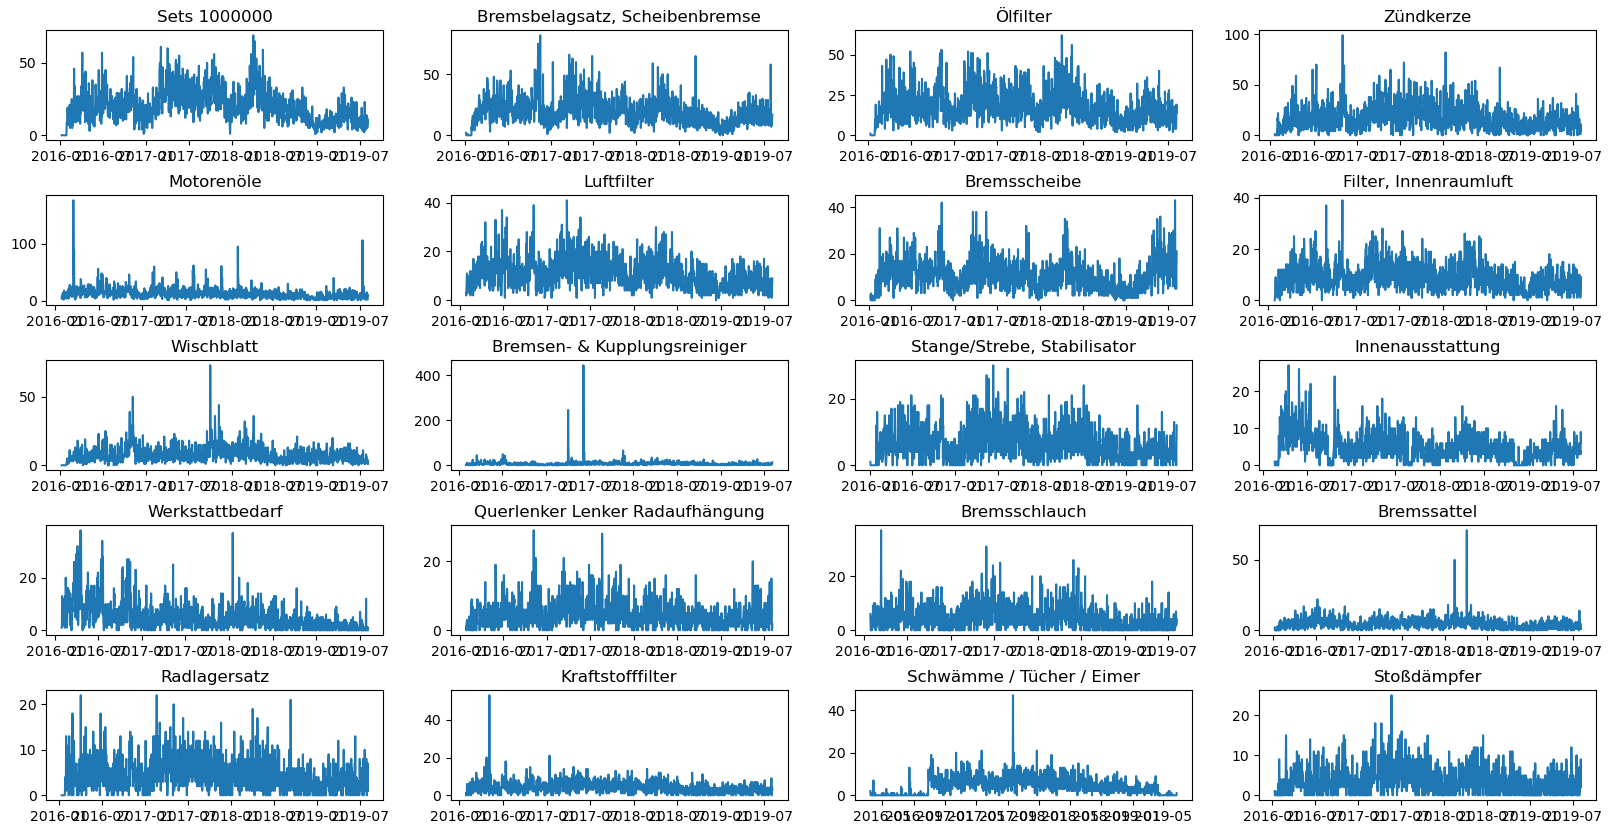

In [29]:
plot_product_groups(prod_group_data=prod_group_data_lott, plot_cols=4, figsize=(20,10))

# Trend detection

## OLS

In [30]:
ols_results_atu = {} # save results in here to plot them later and calculate the MSE later
for key, val in tqdm(prod_group_data_atu.items()): # tqdm() adds the progress bar and does nothing else
    x_values = list(range(len(val.index)))
    res = stats.linregress(x_values, val.y)
    res_values = [res.intercept + x*res.slope for x in x_values]
    ols_results_atu[key] = pd.Series(res_values, index=val.index)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 466.74it/s]


In [31]:
ols_results_lott = {}
for key, val in tqdm(prod_group_data_lott.items()):
    x_values = list(range(len(val.index)))
    res = stats.linregress(x_values, val.y)
    res_values = [res.intercept + x*res.slope for x in x_values]
    ols_results_lott[key] = pd.Series(res_values, index=val.index)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1026.78it/s]


## SSA

In [32]:
ssa_results_atu = {}
for key, val in tqdm(prod_group_data_atu.items()):
    # Extract the 'sales' column from the DataFrame
    window = 200 # samples
    accel_ssa = SSA(val.y, window)

    ssa_results_atu[key] = accel_ssa.reconstruct(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.76s/it]


In [33]:
ssa_results_lott = {}
for key, val in tqdm(prod_group_data_lott.items()):
    # Extract the 'sales' column from the DataFrame
    window = 200 # samples
    accel_ssa = SSA(val.y, window)

    ssa_results_lott[key] = accel_ssa.reconstruct(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.45s/it]


## LWPR

In [34]:
# Function to apply LOESS
def apply_loess(data, frac=0.2, degree=2):
    lowess = sm.nonparametric.lowess
    result = lowess(data['y'], data.index, frac=frac, it=5, delta=0.0, is_sorted=True, missing='drop', return_sorted=False)
    return result

In [35]:
lwpr_results_atu = {}
for key, val in tqdm(prod_group_data_atu.items()):
    loess_result = apply_loess(val)

    lwpr_results_atu[key] = pd.Series(loess_result, index=val.index)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.51it/s]


In [36]:
lwpr_results_lott = {}
for key, val in tqdm(prod_group_data_lott.items()):
    loess_result = apply_loess(val)

    lwpr_results_lott[key] = pd.Series(loess_result, index=val.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.61it/s]


## EMD

In [37]:
emd_results_atu = {}
for key, val in tqdm(prod_group_data_atu.items()):
    emd = EMD()
    
    # Decompose the time series
    imfs_and_residue = emd(val.y.values, max_imf=10)
    
    # Extract IMFs and residue
    imfs = imfs_and_residue[:-1]
    residue = imfs_and_residue[-1]

    # Combine IMFs to get the trend
    trend = sum(imfs)

    emd_results_atu[key] = pd.Series(residue, index=val.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


In [38]:
emd_results_lott = {}
for key, val in tqdm(prod_group_data_lott.items()):
    emd = EMD()
    
    # Decompose the time series
    imfs_and_residue = emd(val.y.values, max_imf=10)
    
    # Extract IMFs and residue
    imfs = imfs_and_residue[:-1]
    residue = imfs_and_residue[-1]

    # Combine IMFs to get the trend
    trend = sum(imfs)

    emd_results_lott[key] = pd.Series(residue, index=val.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.81it/s]


# Plot

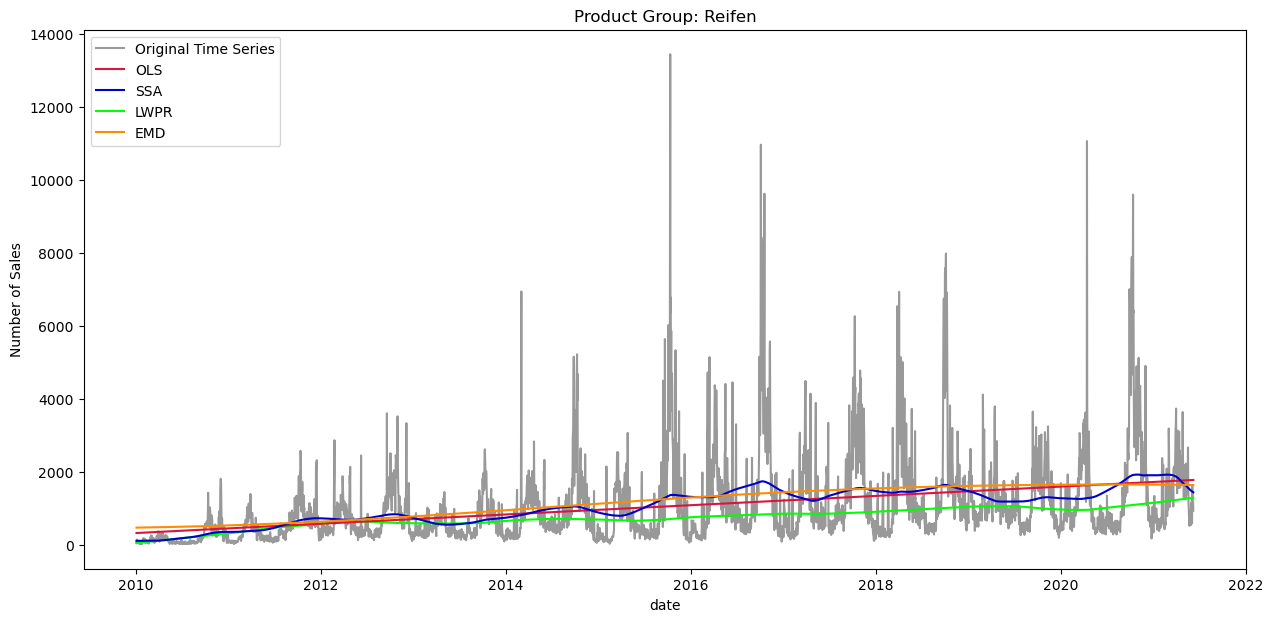

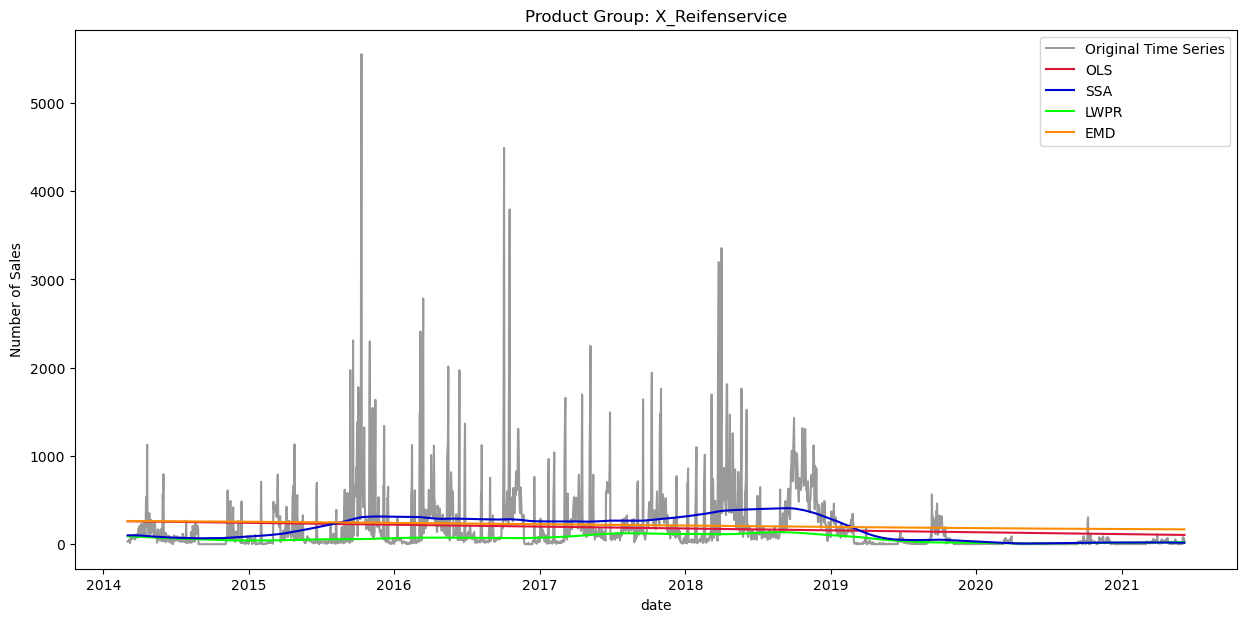

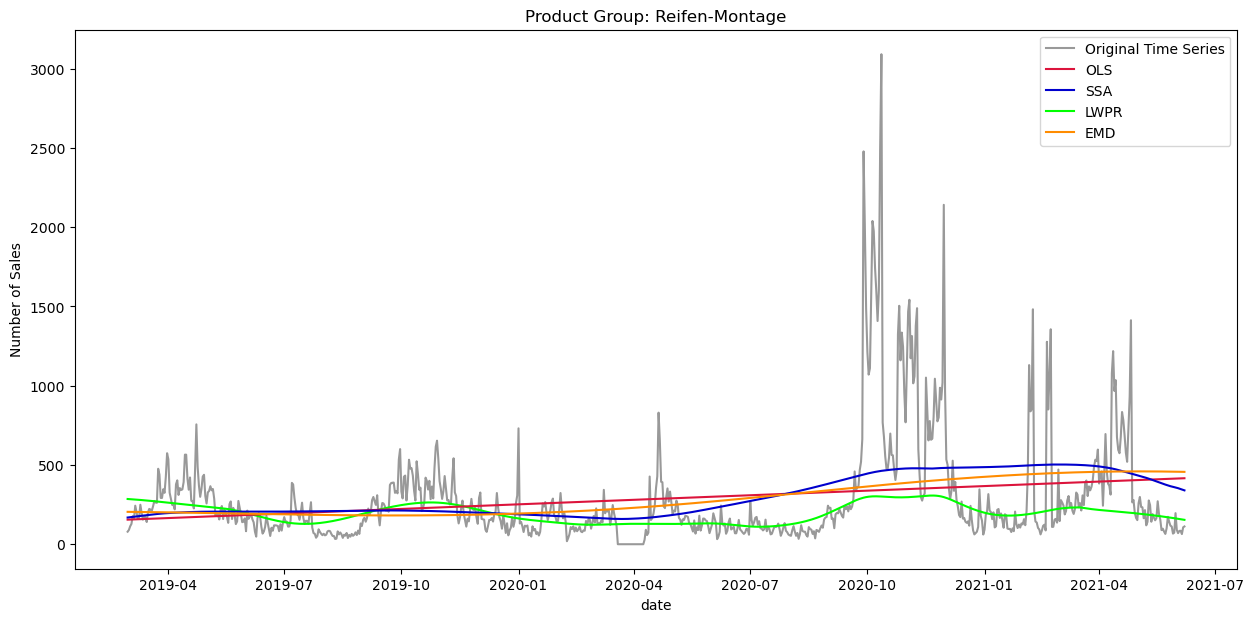

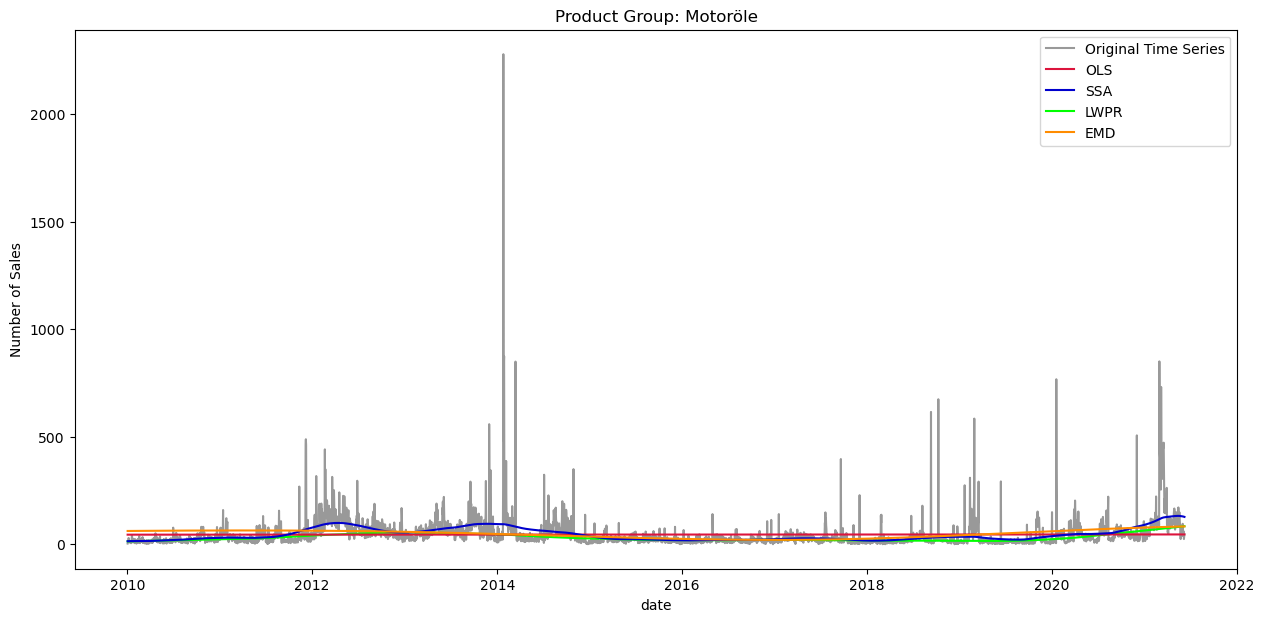

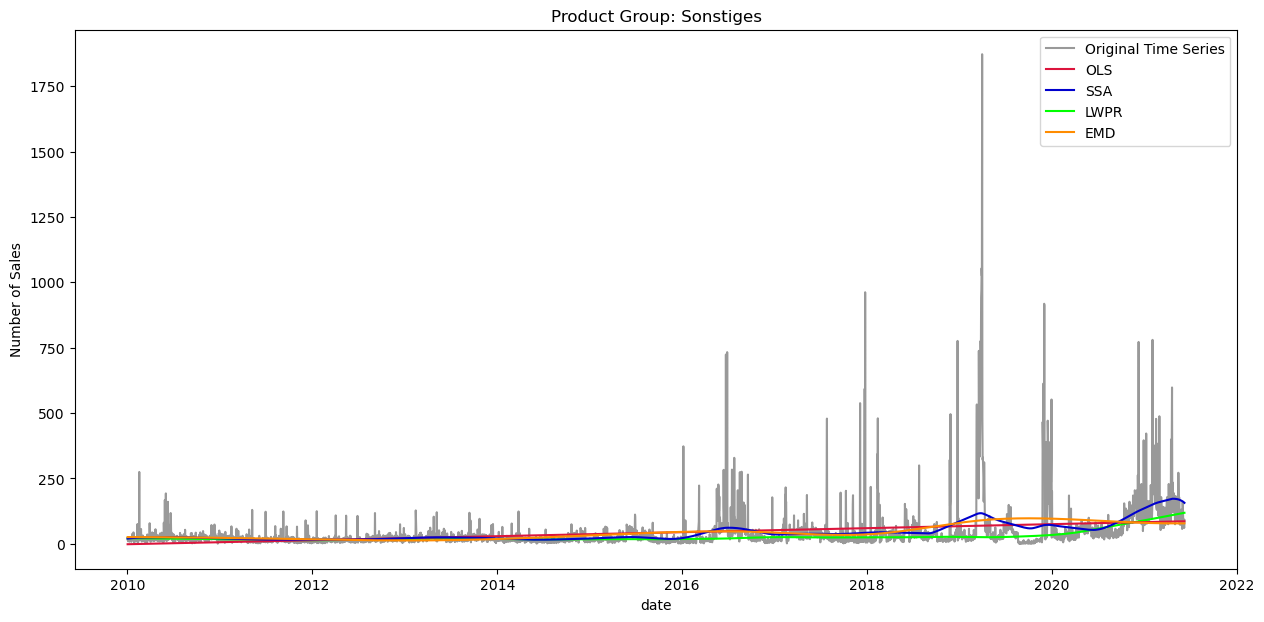

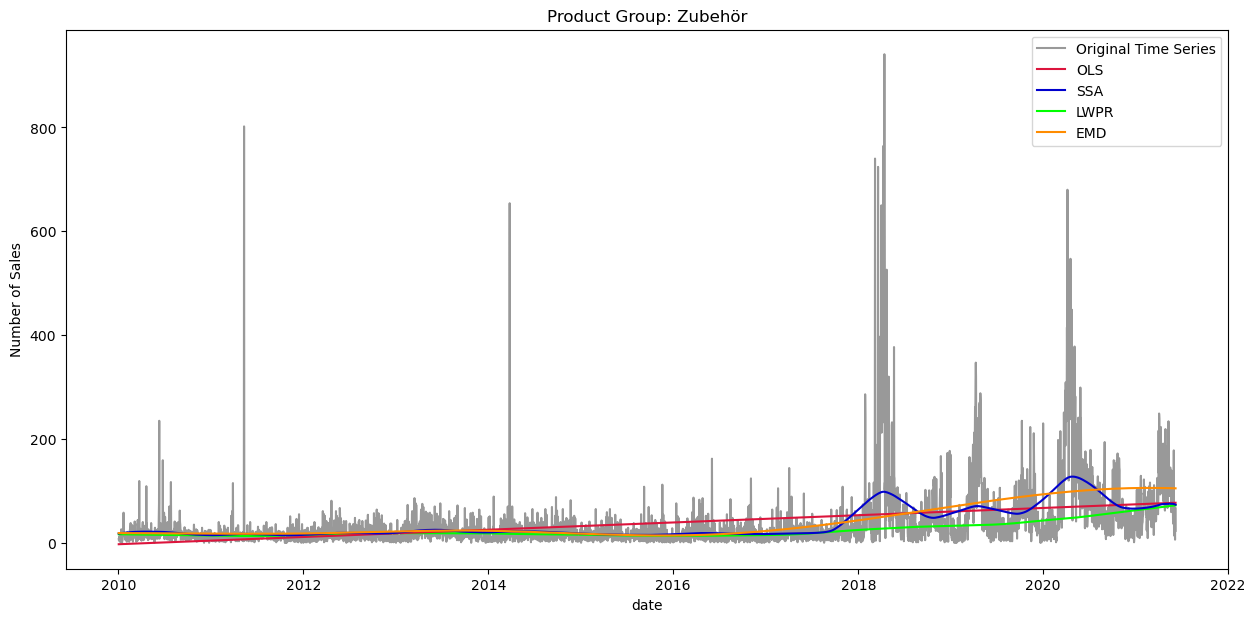

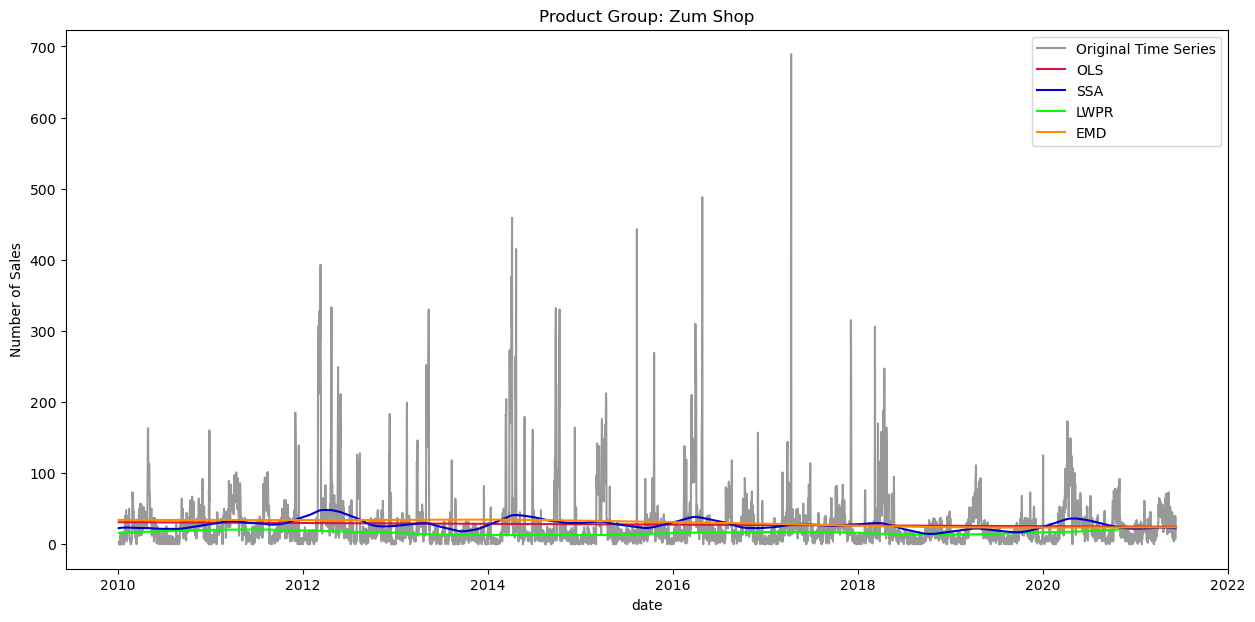

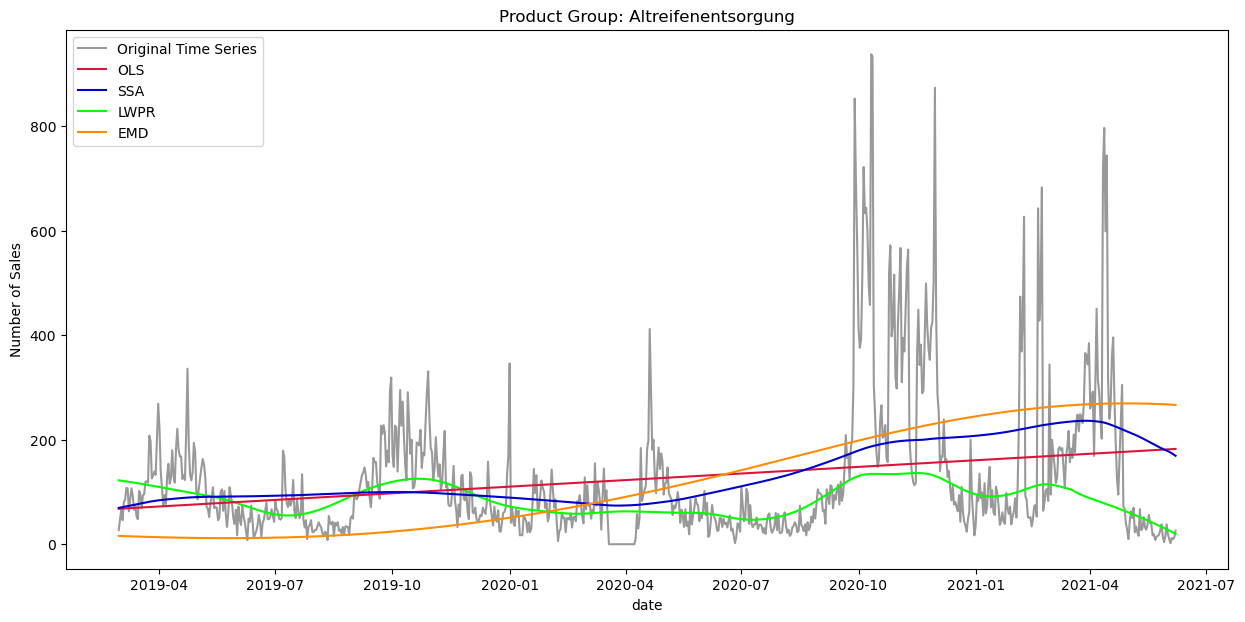

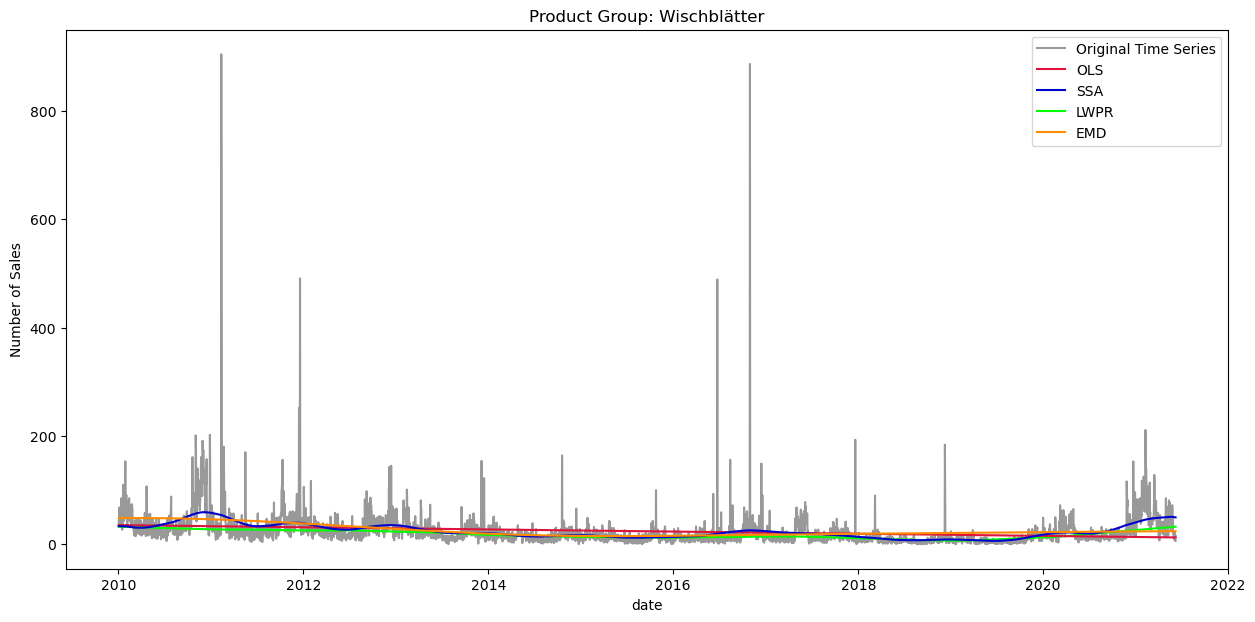

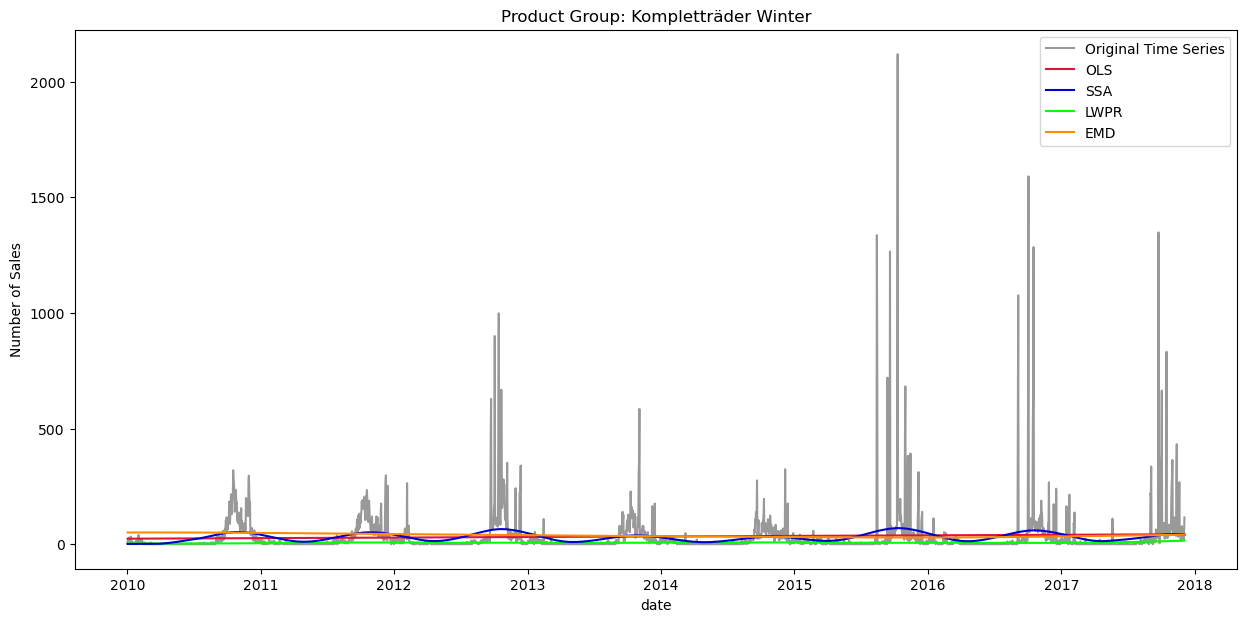

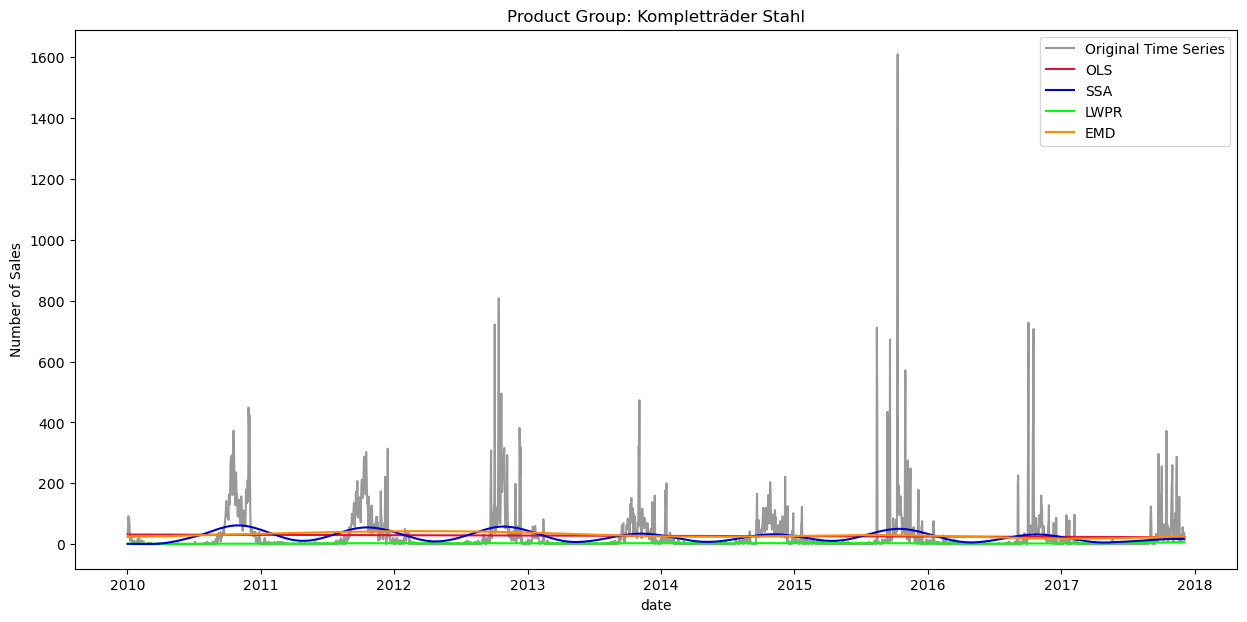

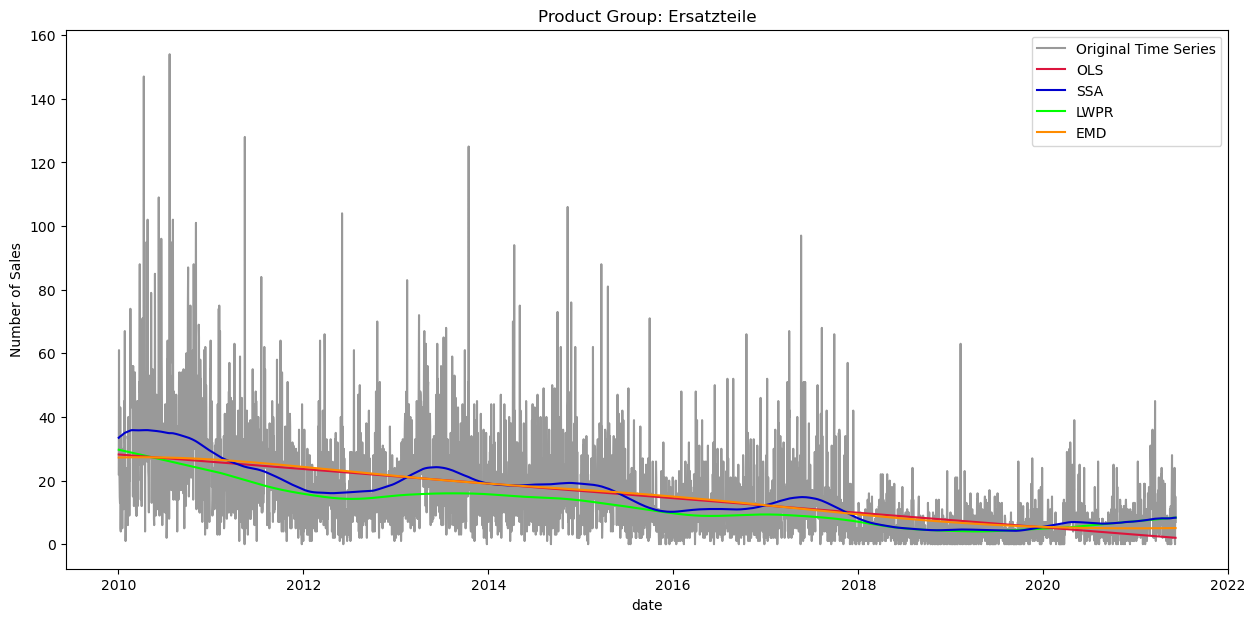

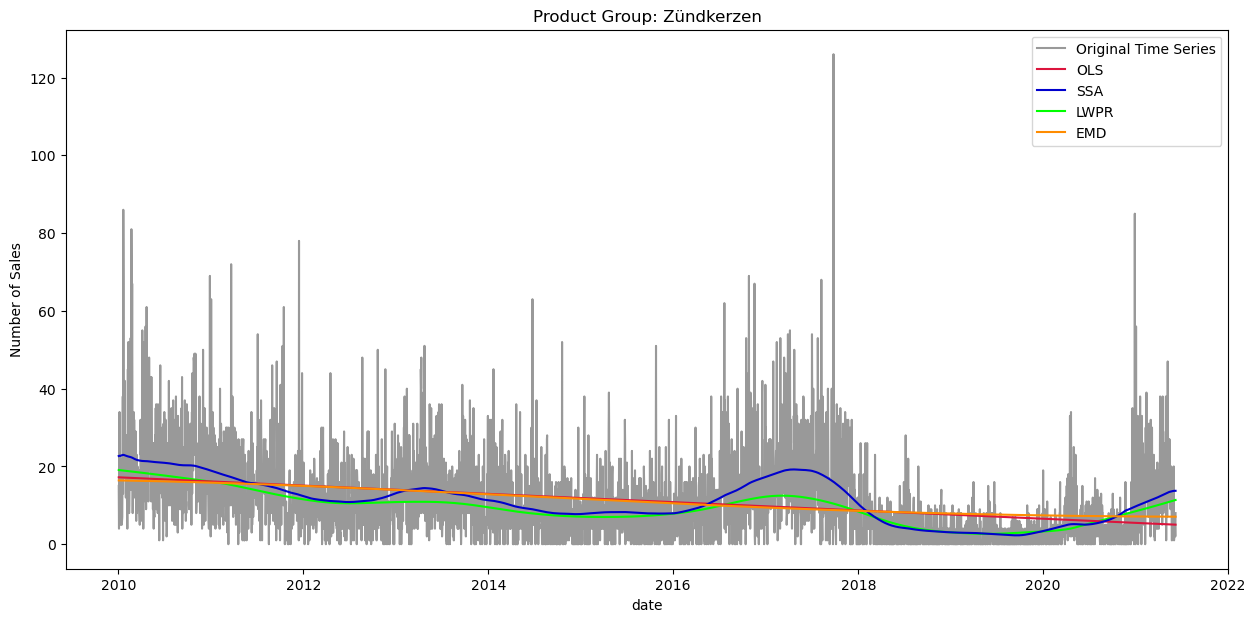

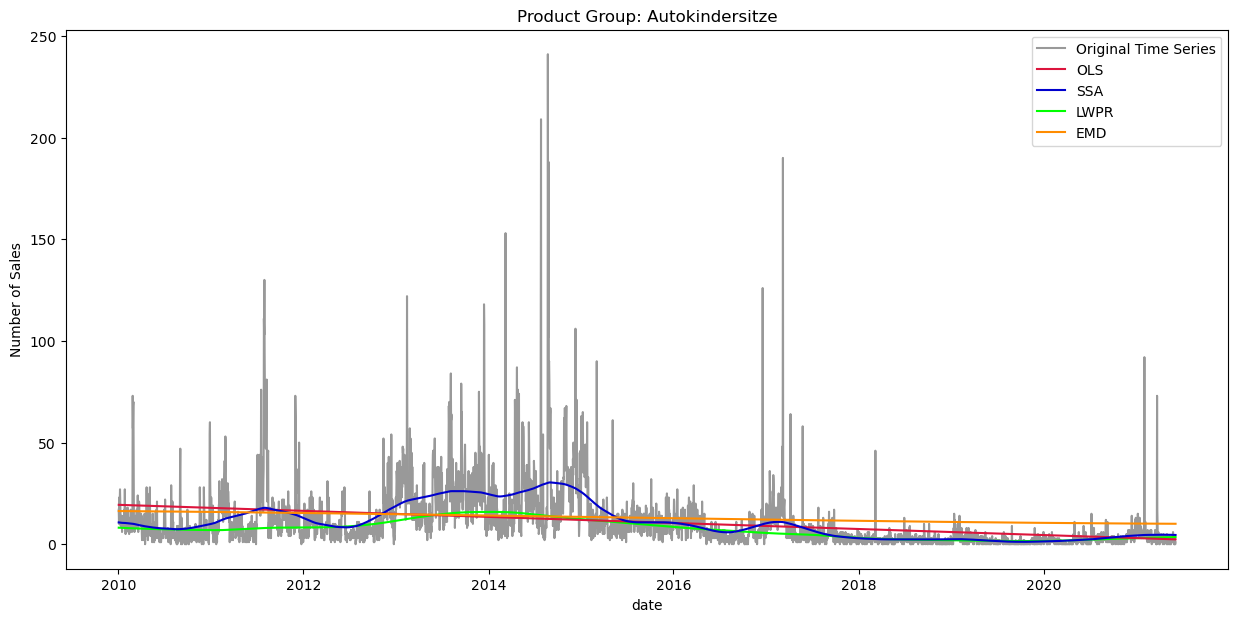

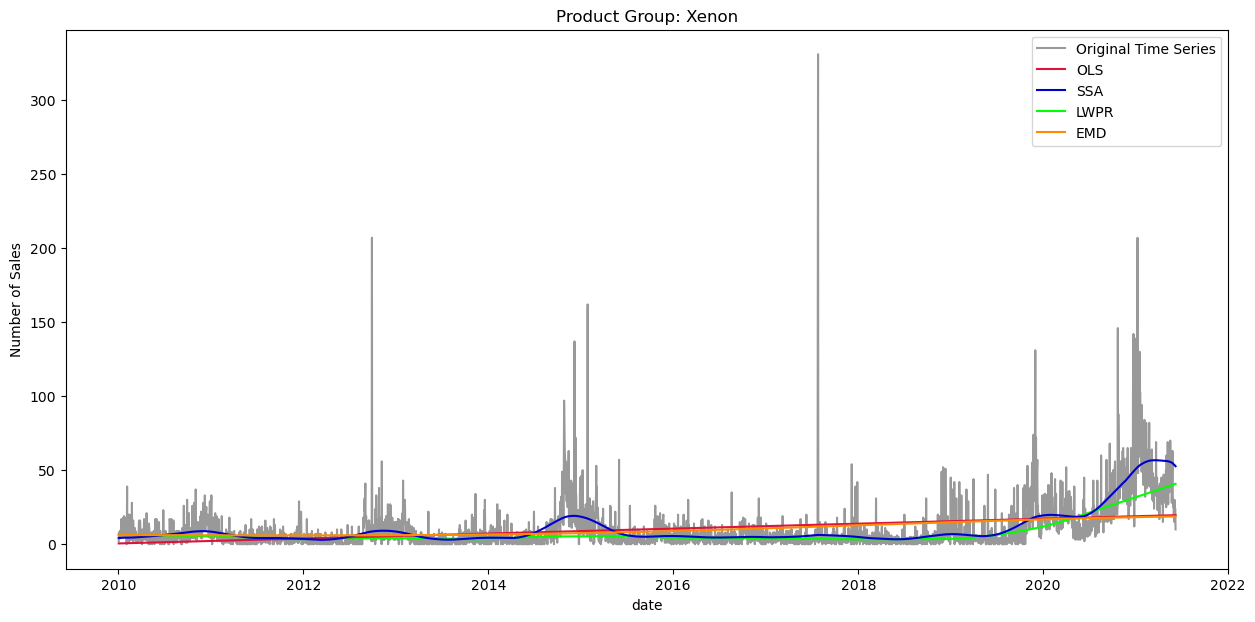

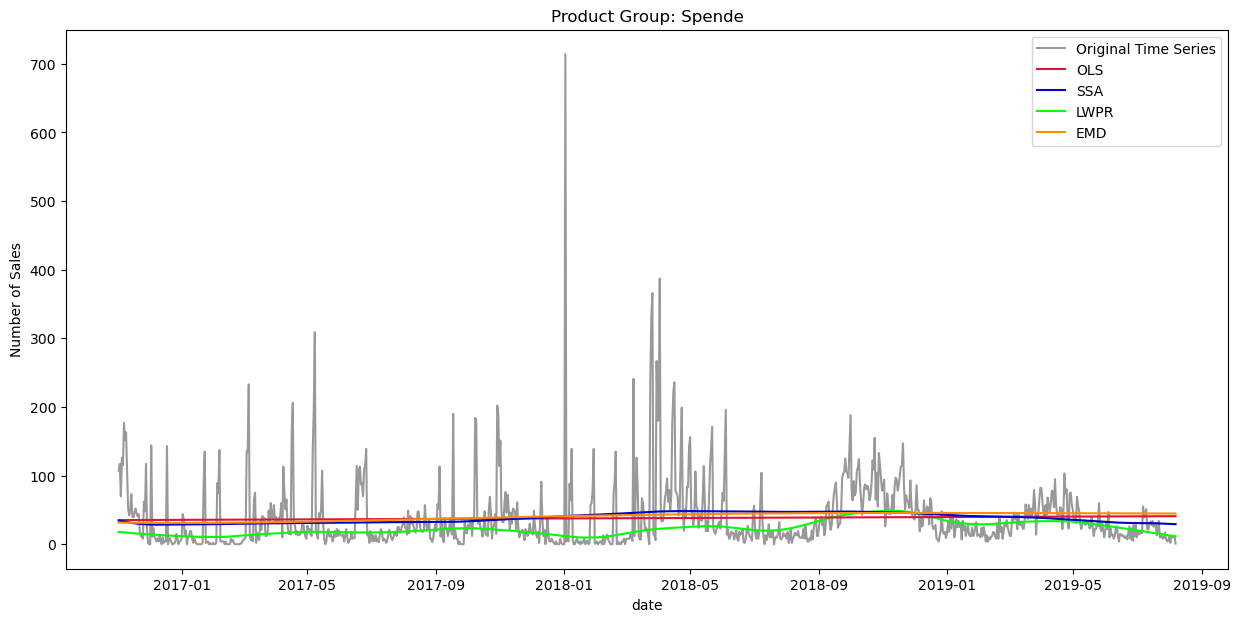

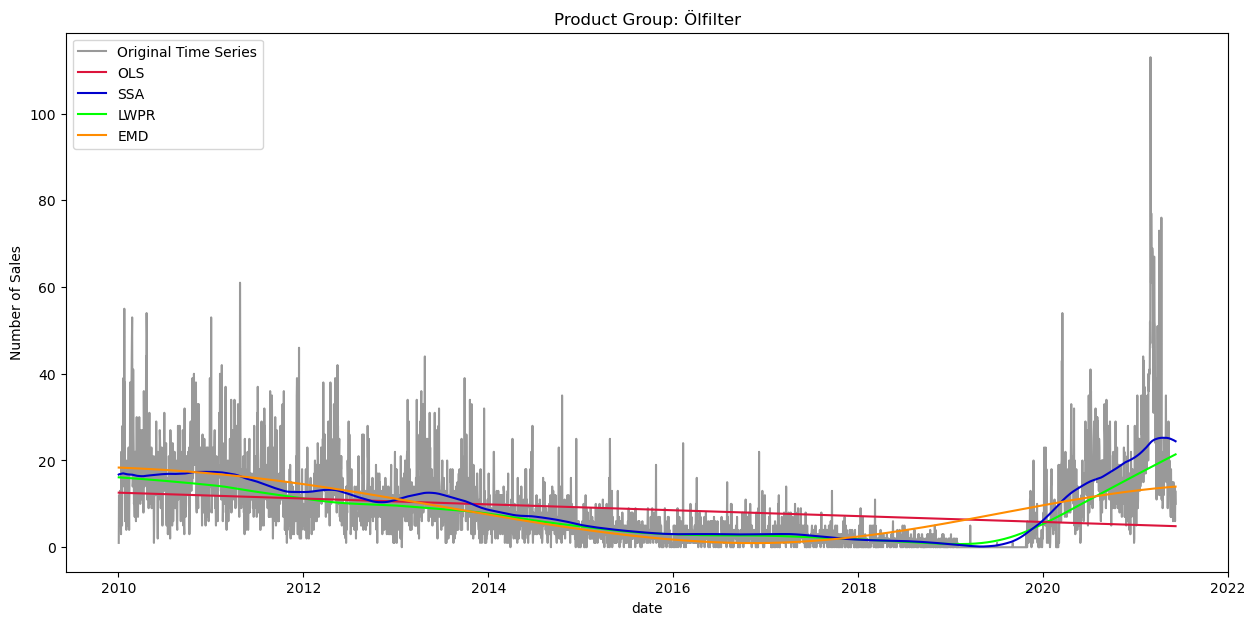

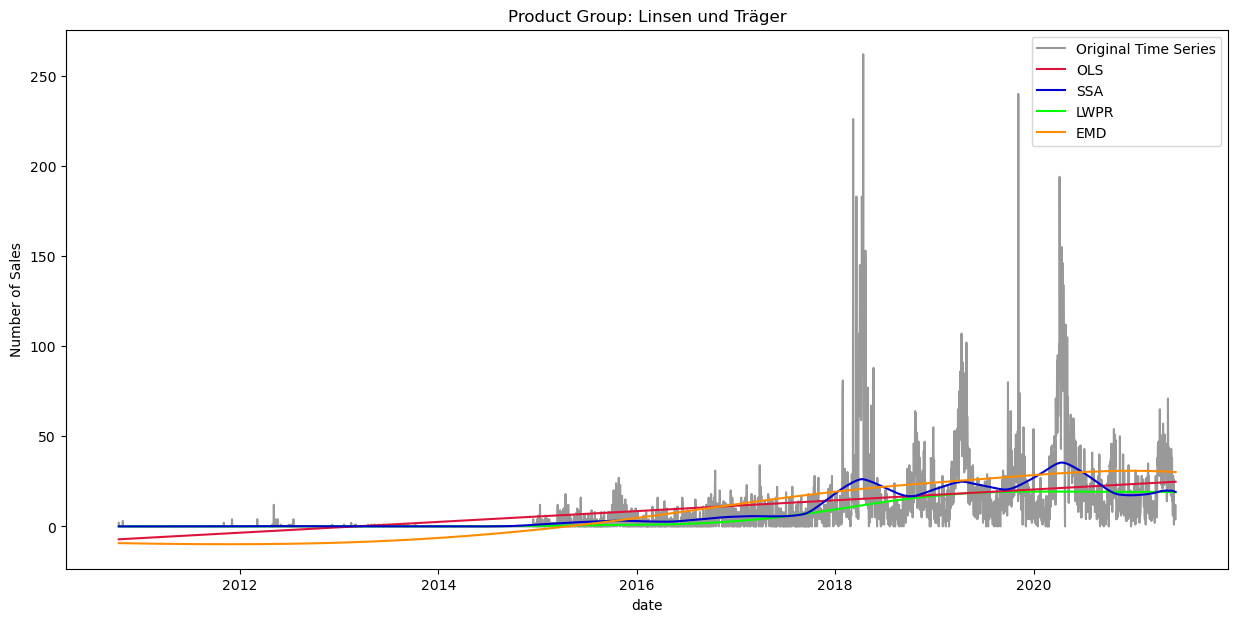

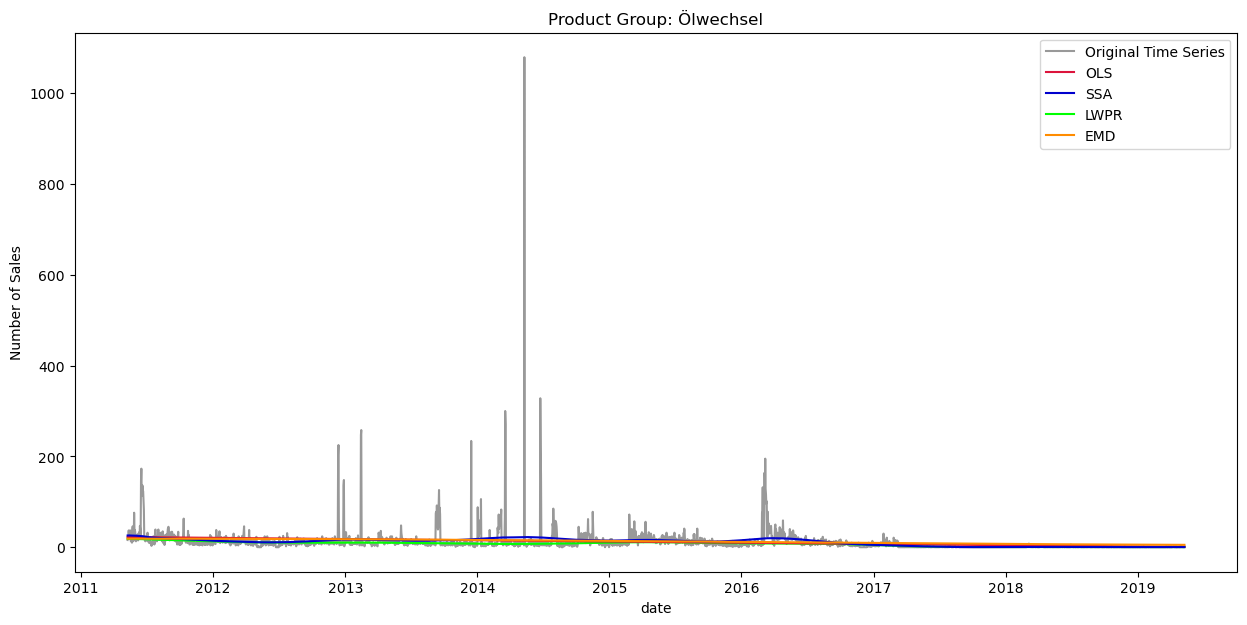

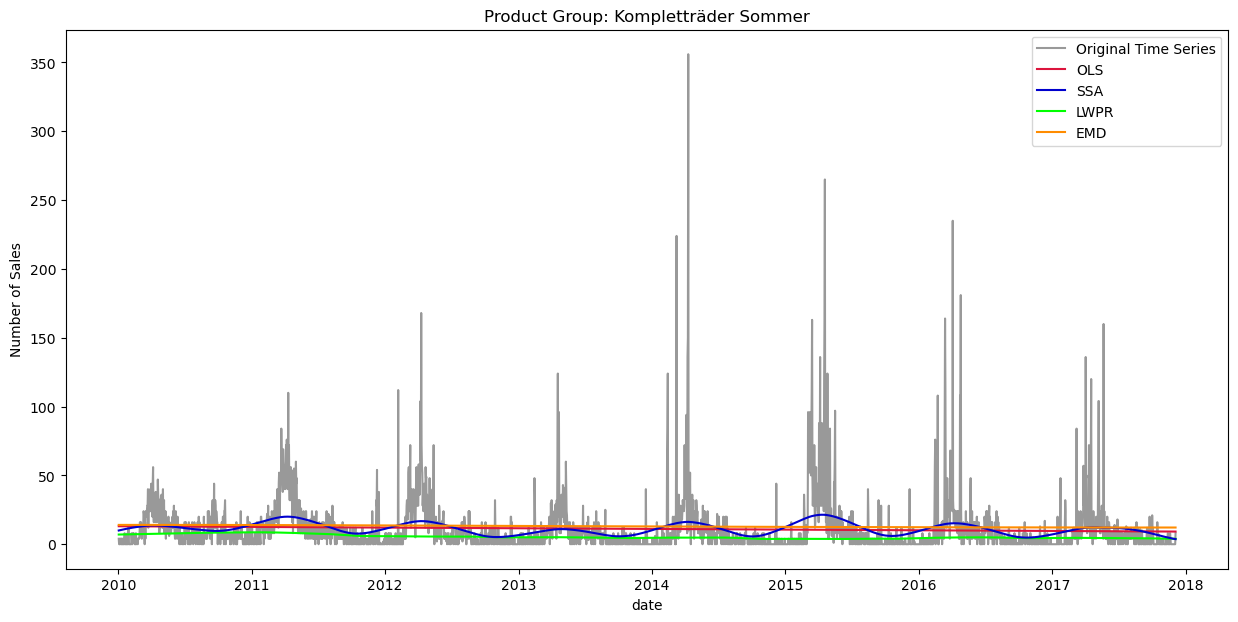

In [39]:
for key, val in prod_group_data_atu.items():
    plt.figure(figsize=(15,7))
    plt.plot(val, color='black', label='Original Time Series', alpha=0.4, zorder=0)
    plt.plot(ols_results_atu[key], color='crimson', label='OLS', zorder=1)
    plt.plot(ssa_results_atu[key], color='mediumblue', label='SSA', zorder=2)
    plt.plot(lwpr_results_atu[key], color='lime', label='LWPR', zorder=0.5)
    plt.plot(emd_results_atu[key], color='darkorange', label='EMD', zorder=4)
    
    plt.title(f'Product Group: {key}')
    plt.xlabel('date')
    plt.ylabel('Number of Sales')
    plt.legend()
    plt.show()

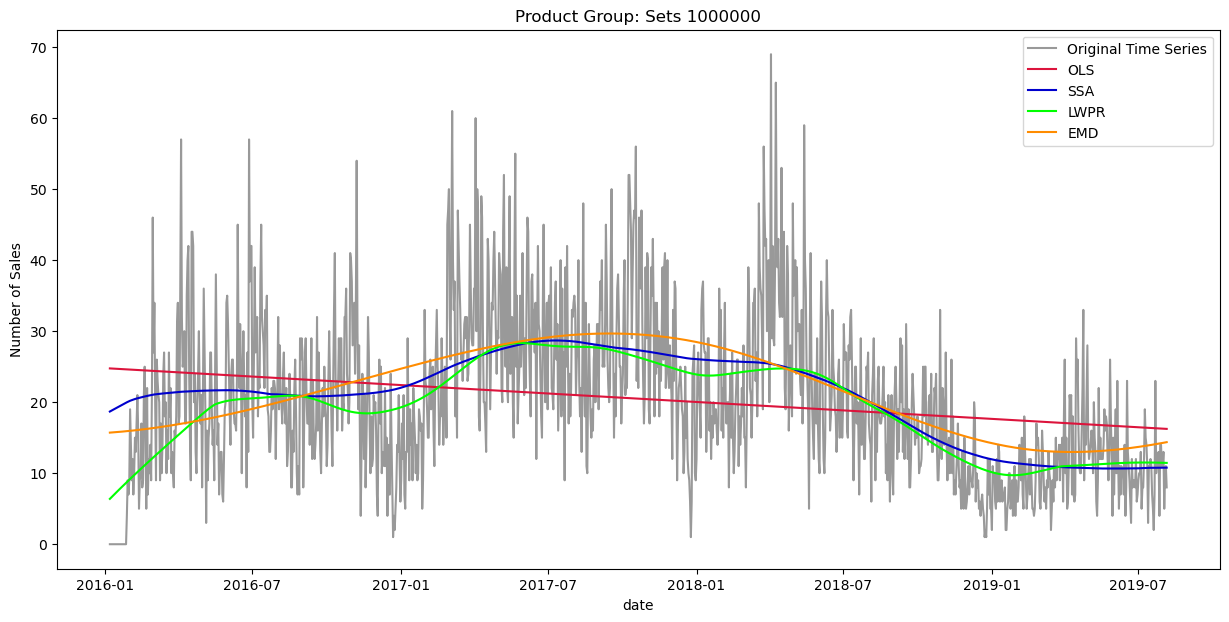

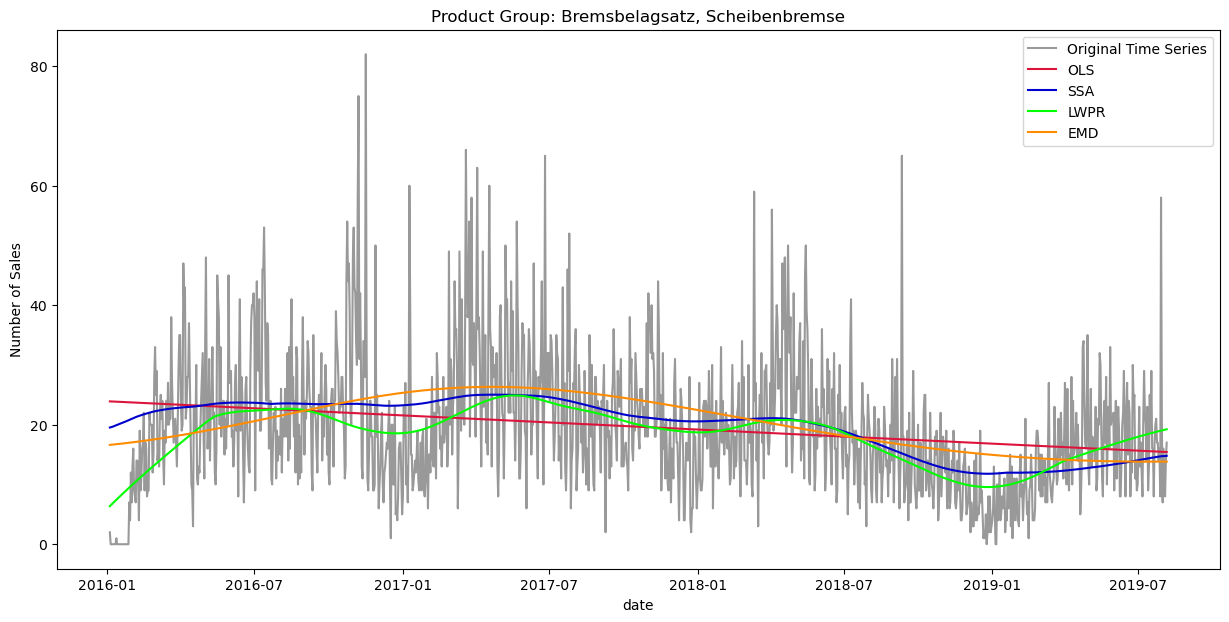

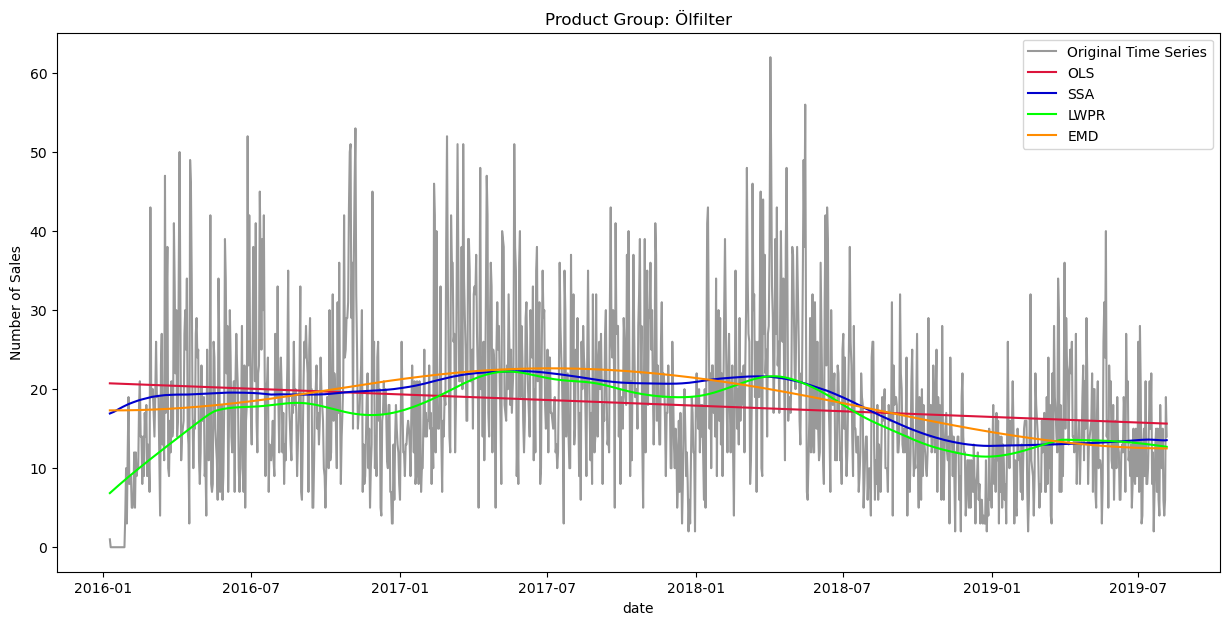

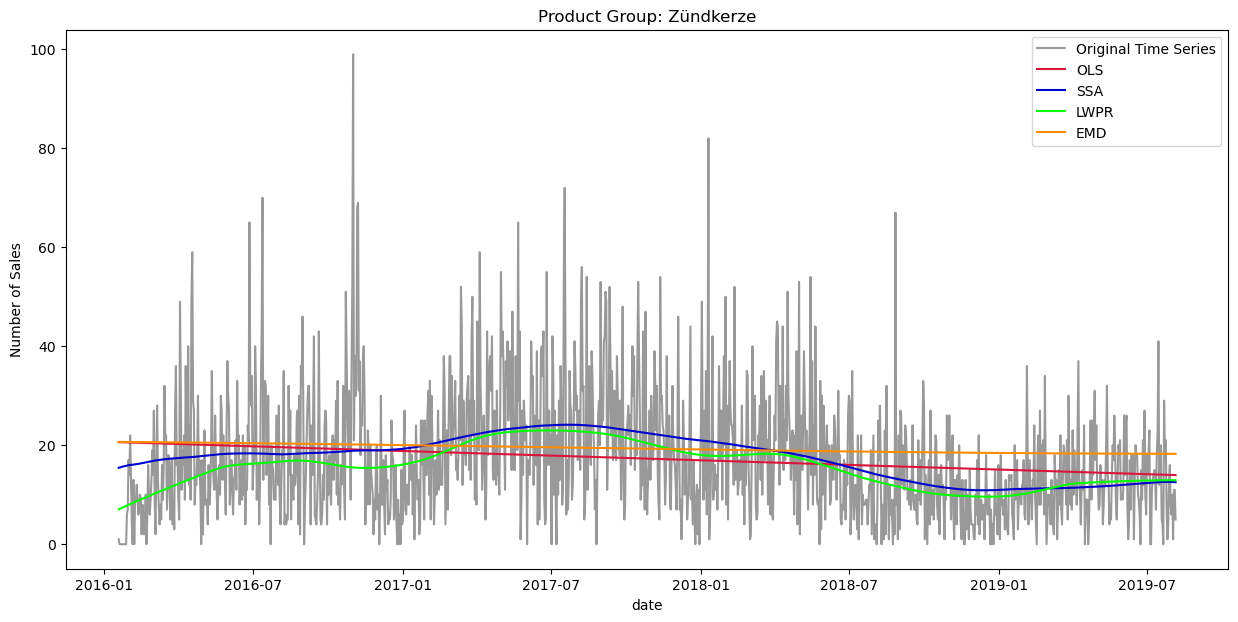

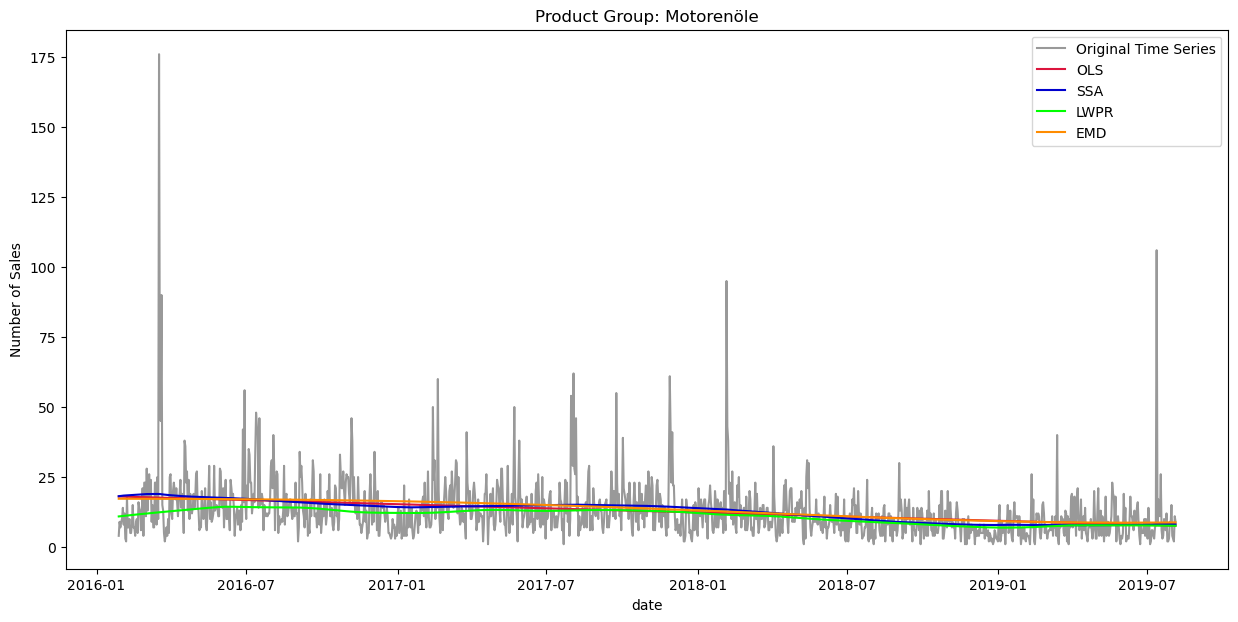

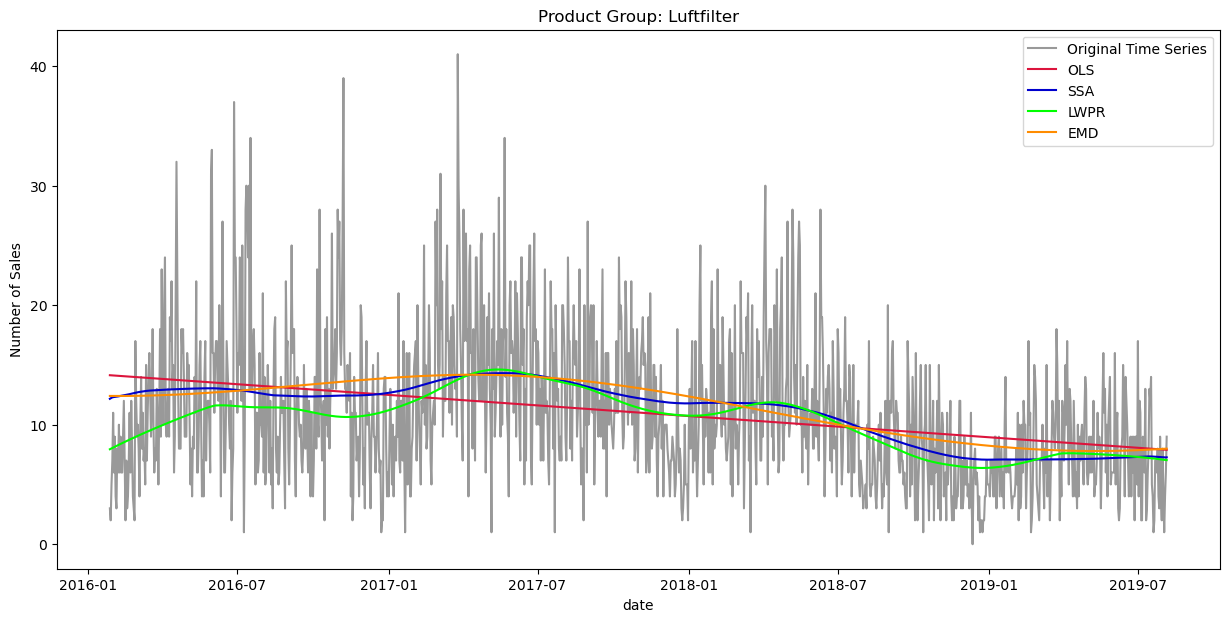

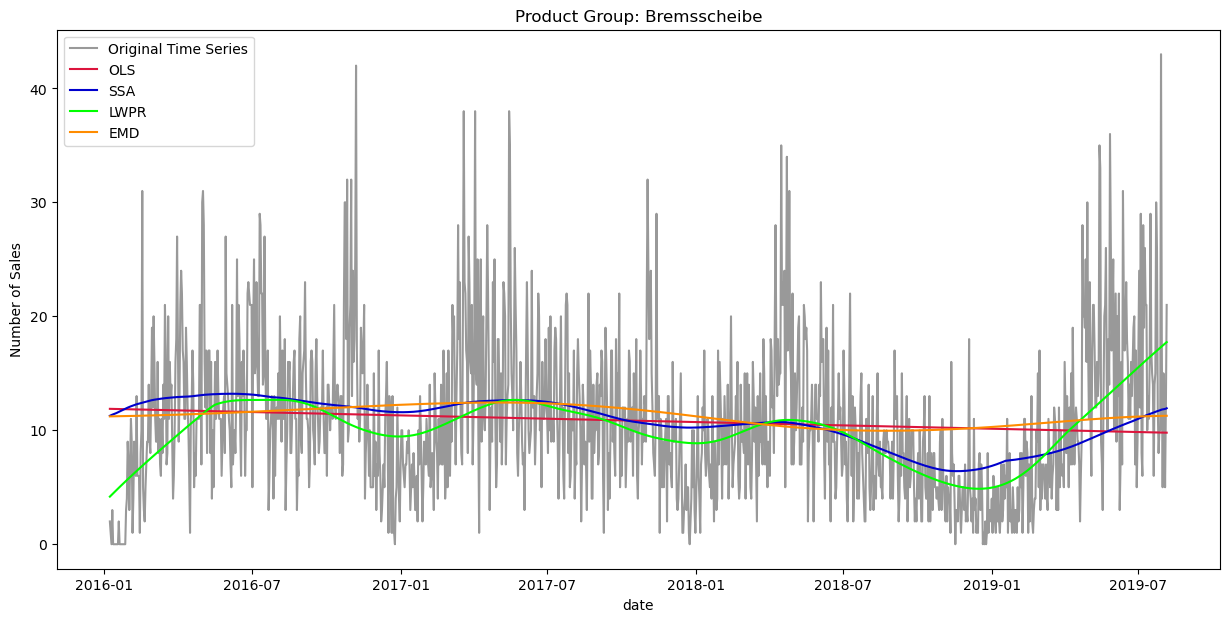

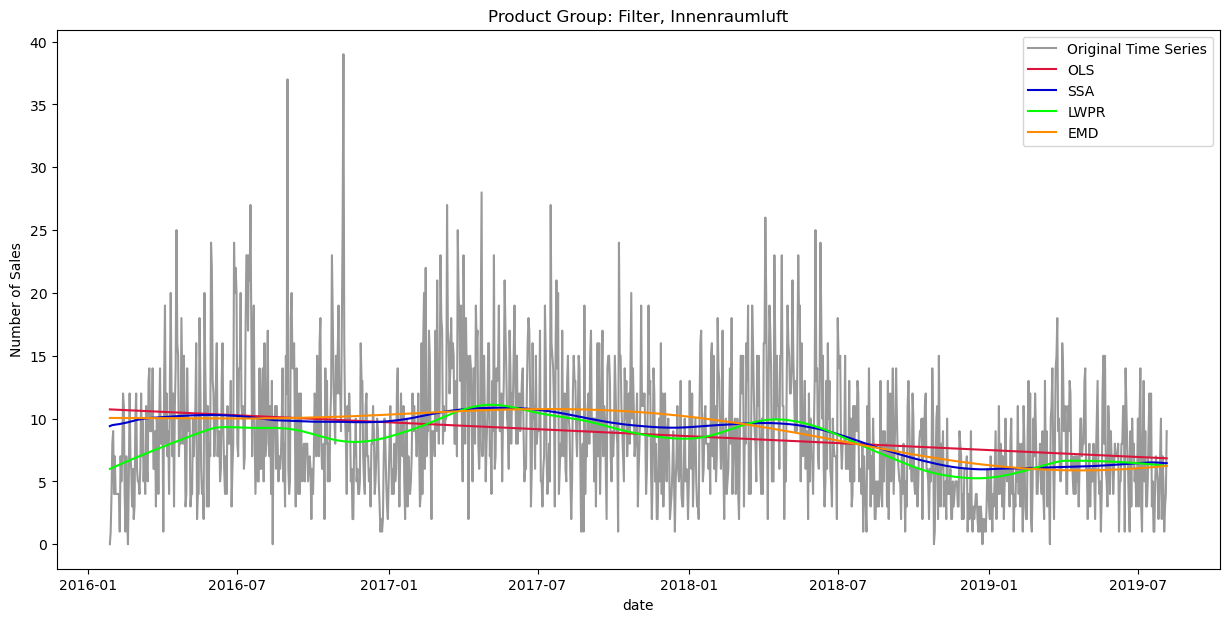

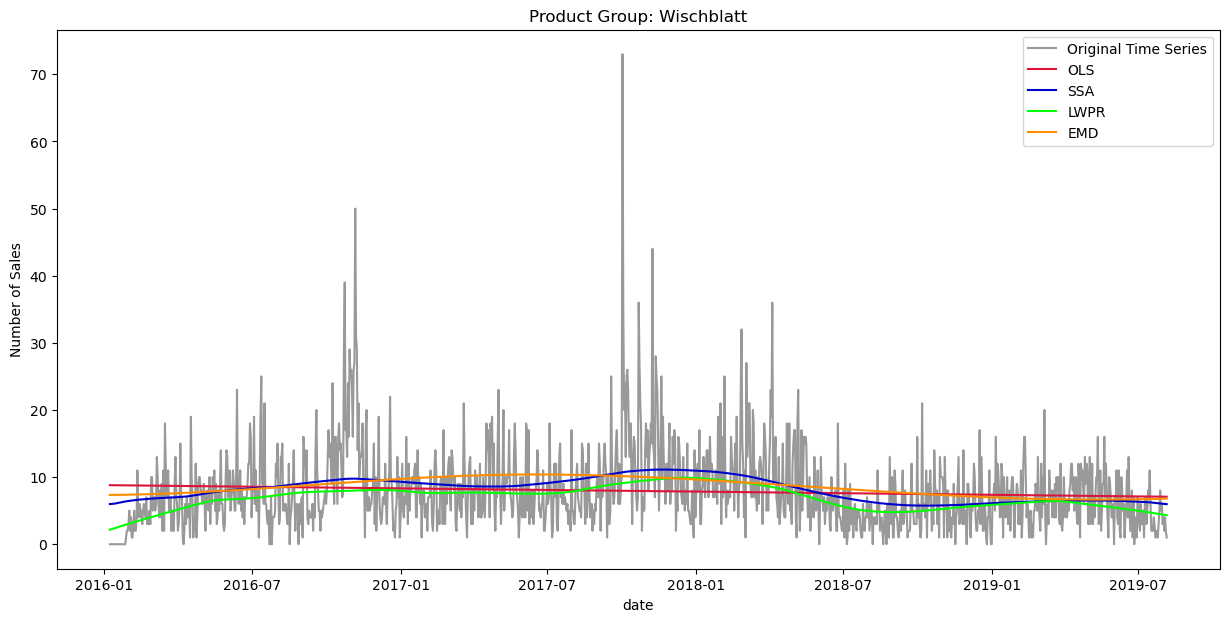

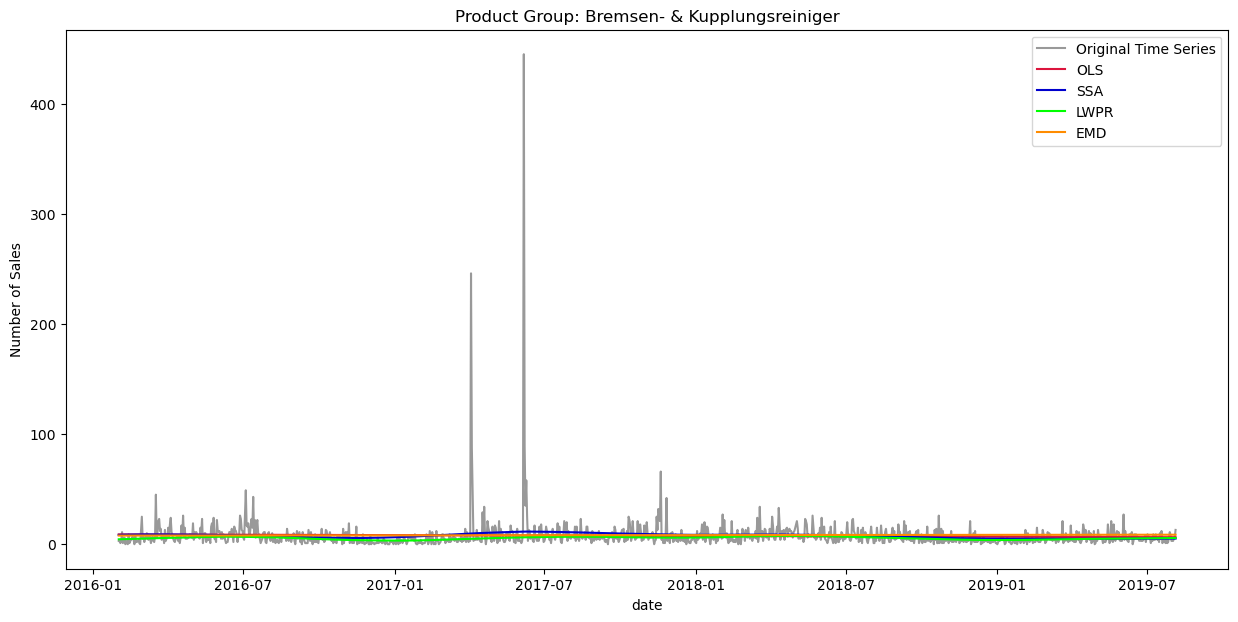

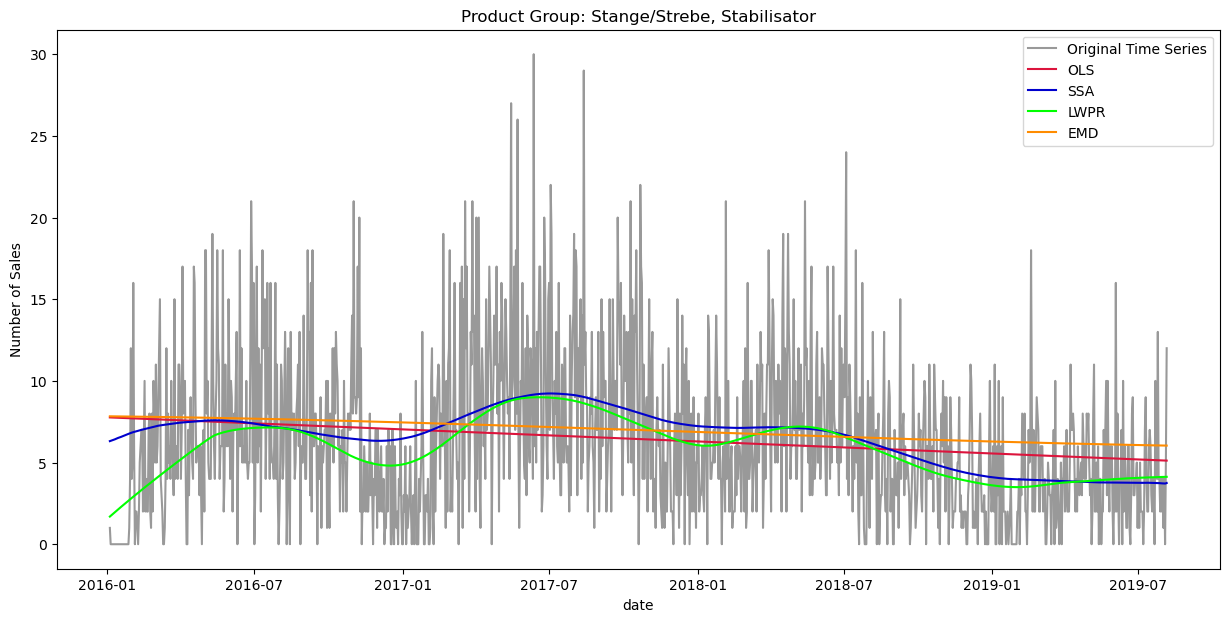

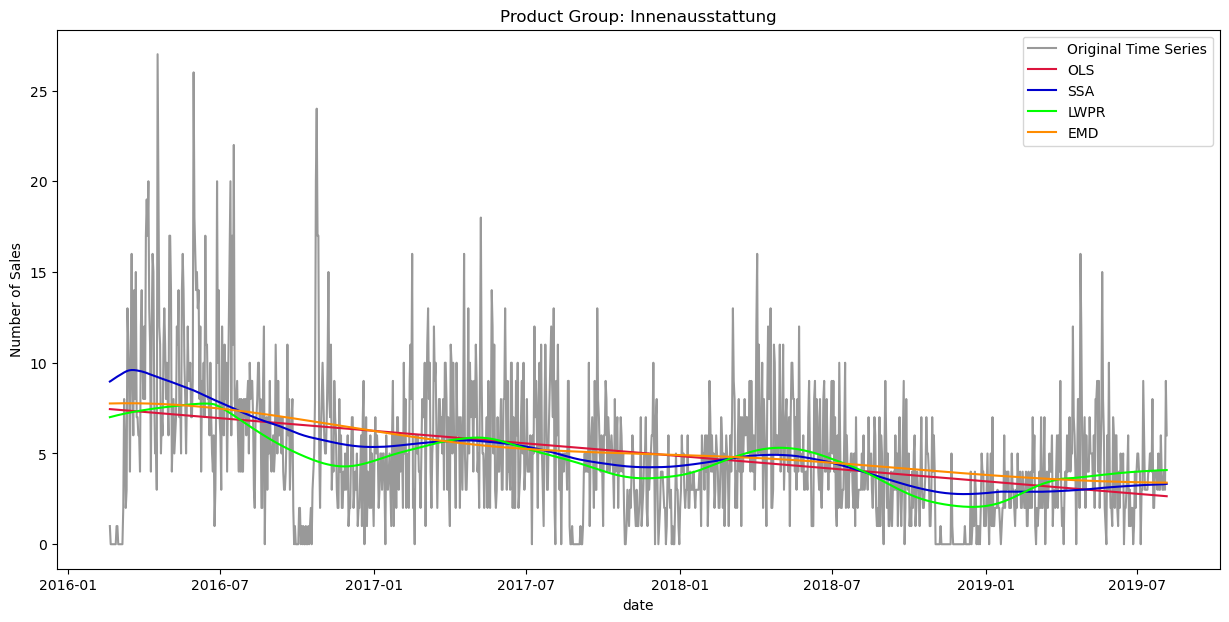

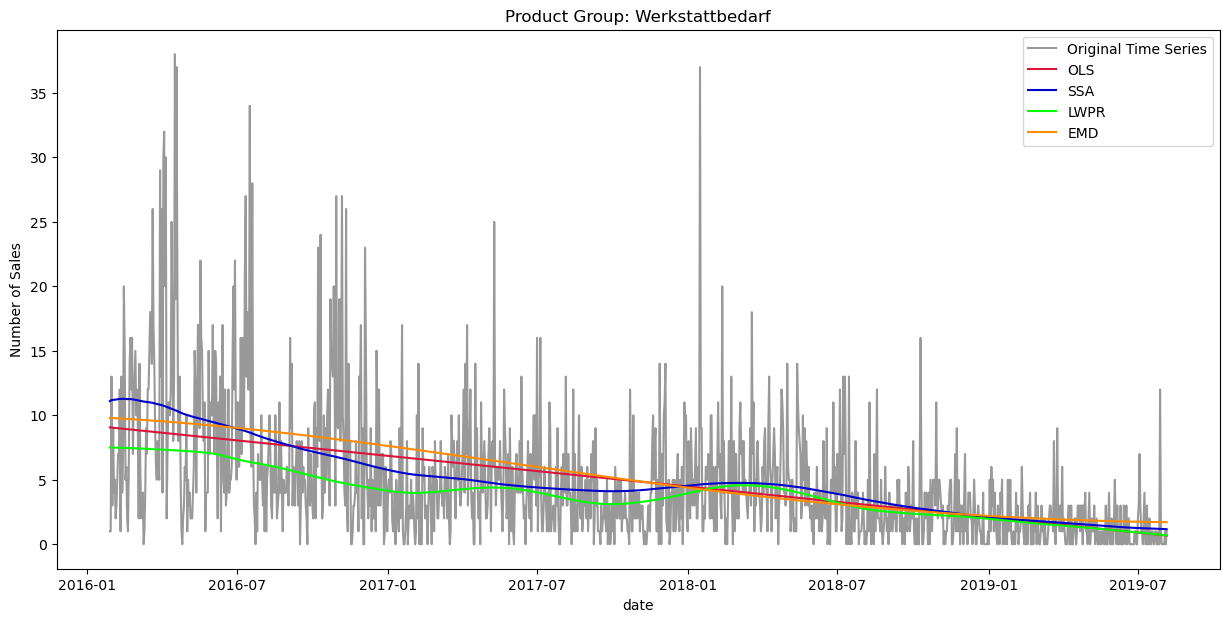

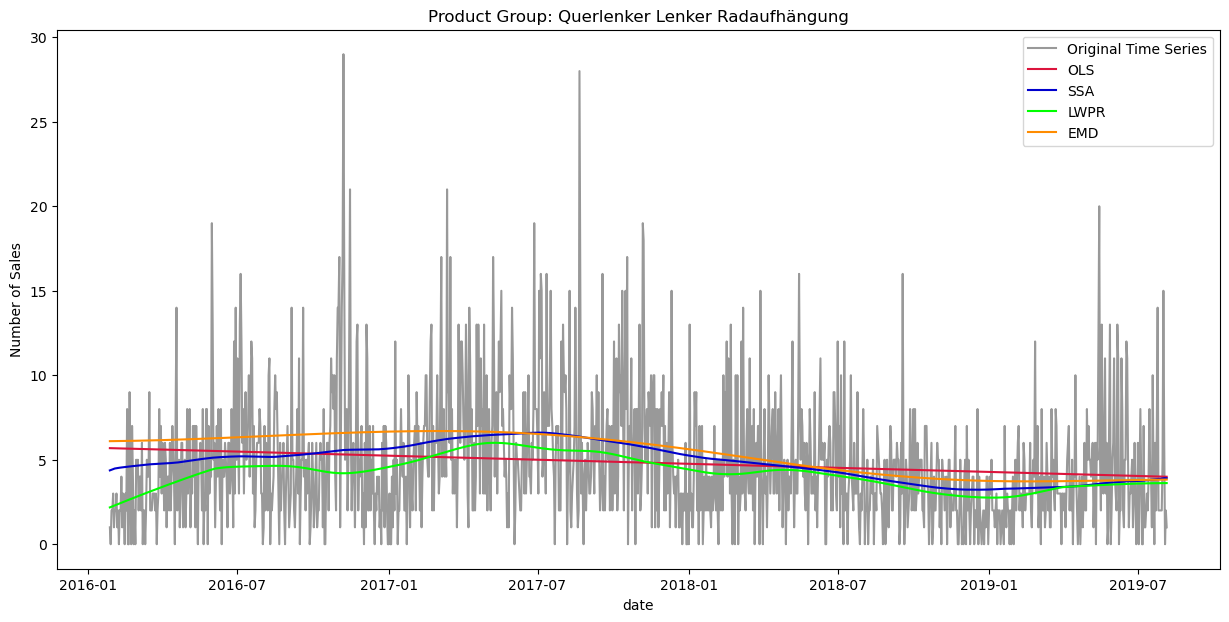

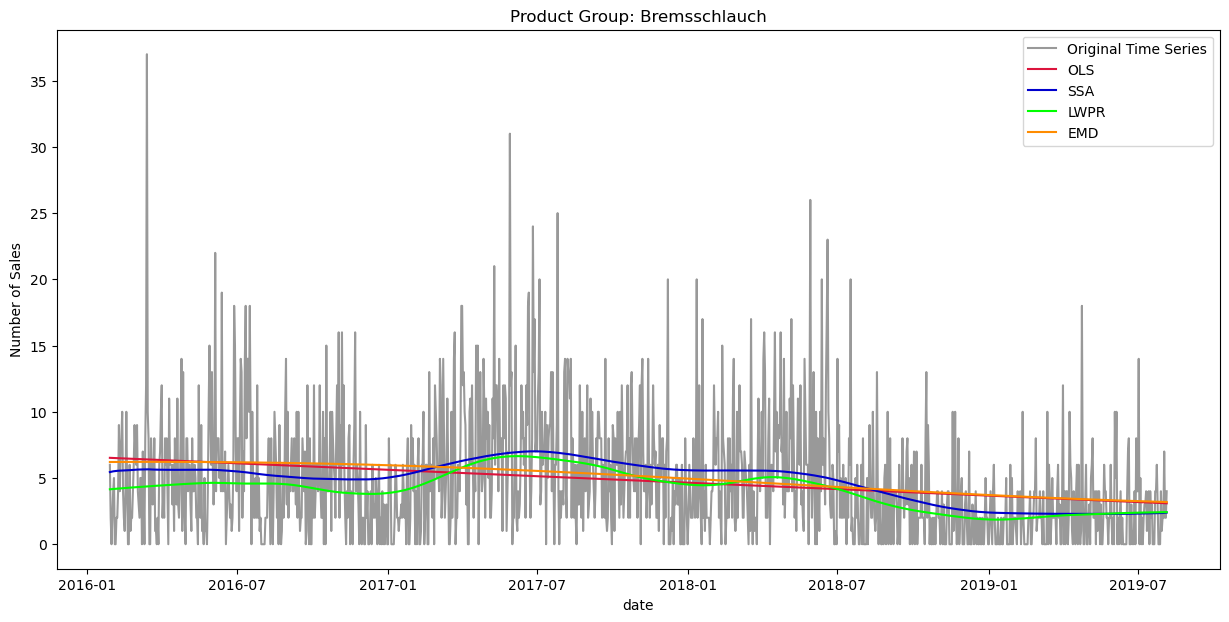

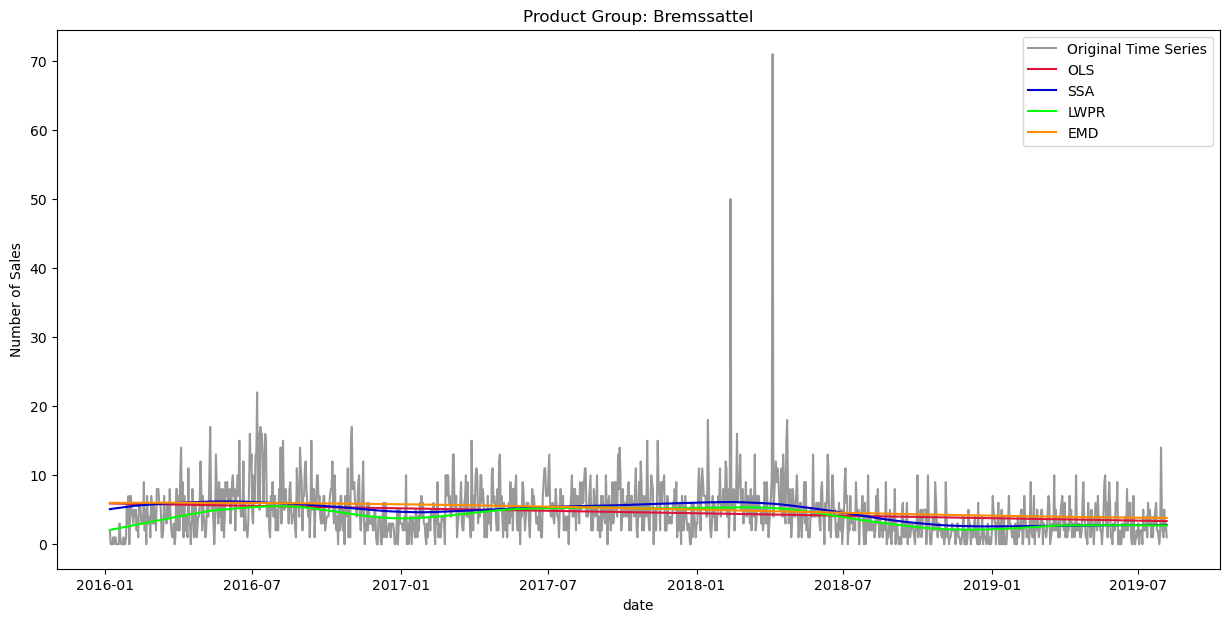

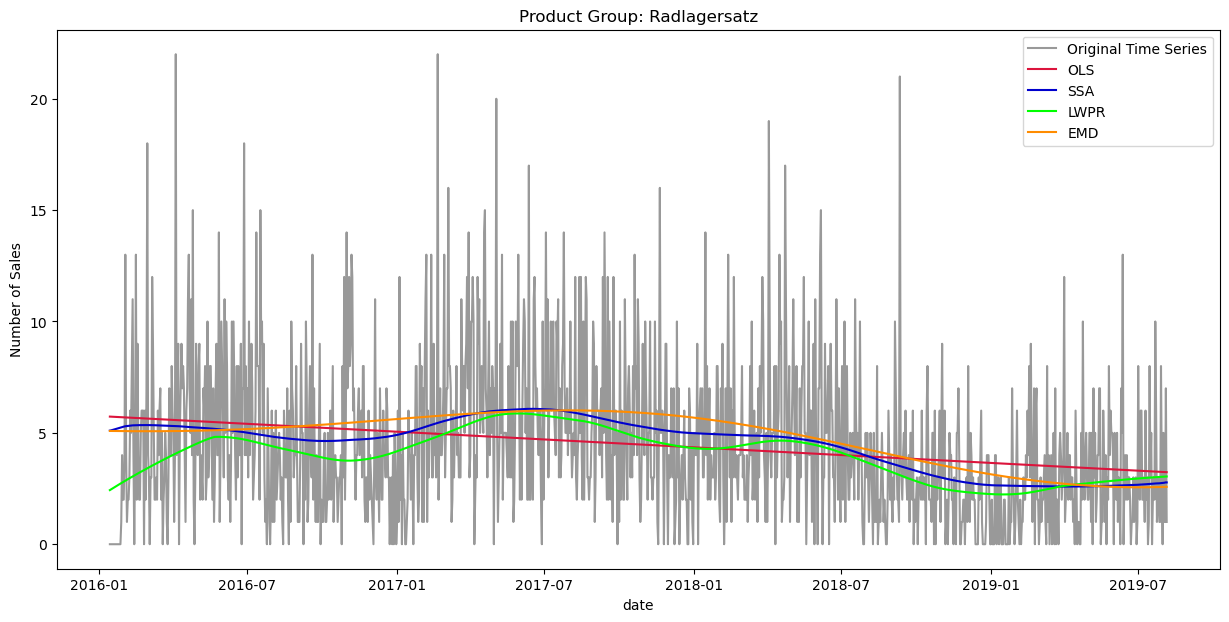

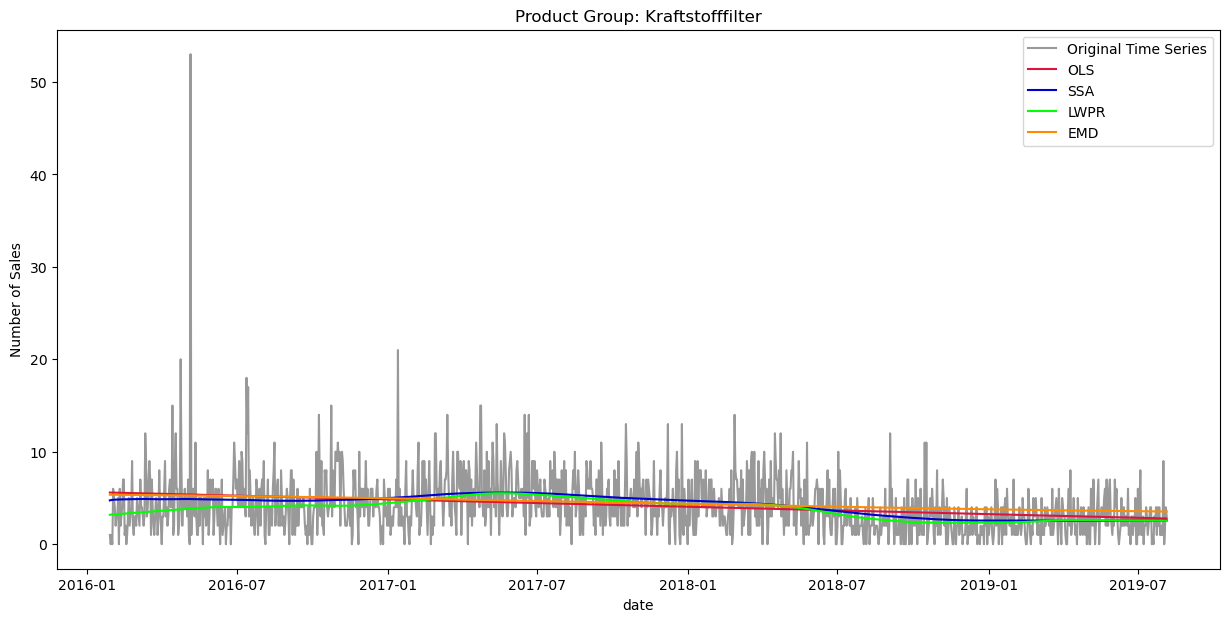

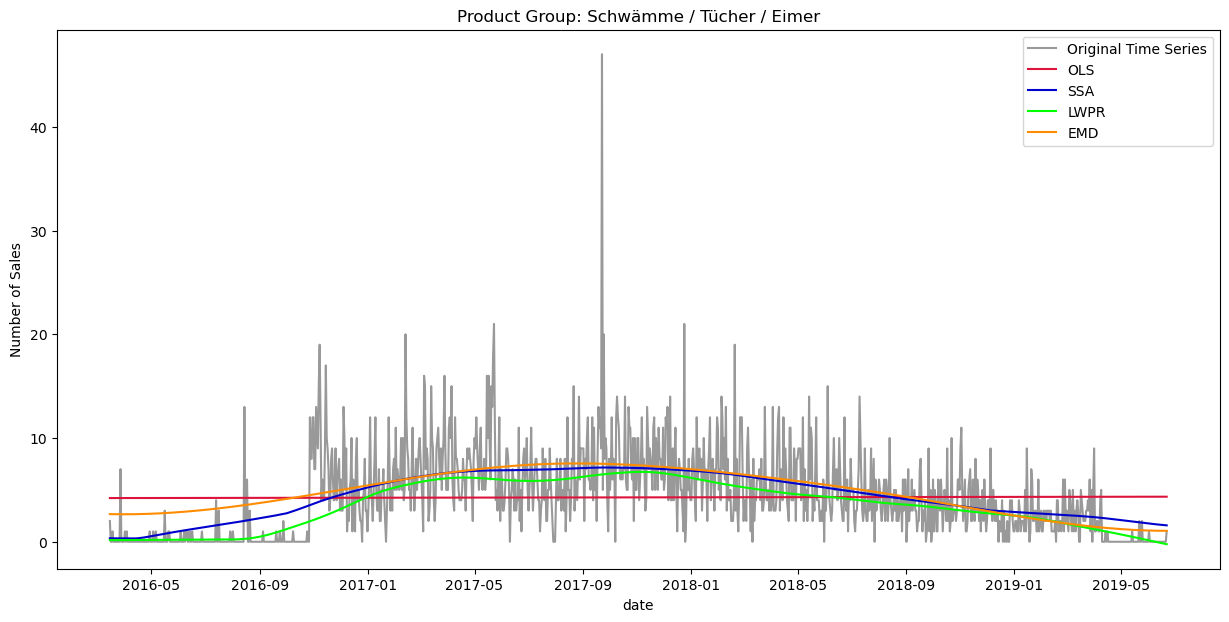

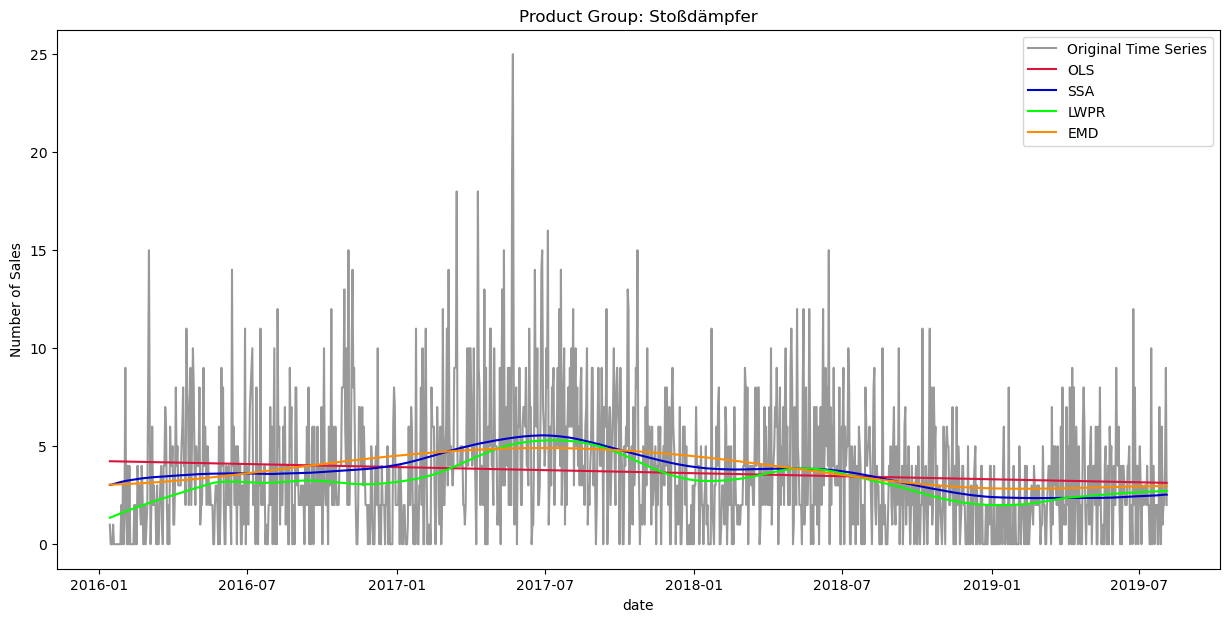

In [40]:
for key, val in prod_group_data_lott.items():
    plt.figure(figsize=(15,7))
    plt.plot(val, alpha=0.4, color='black', label='Original Time Series', zorder=0)
    plt.plot(ols_results_lott[key], color='crimson', label='OLS', zorder=1)
    plt.plot(ssa_results_lott[key], color='mediumblue', label='SSA', zorder=2)
    plt.plot(lwpr_results_lott[key], color='lime', label='LWPR', zorder=3)
    plt.plot(emd_results_lott[key], color='darkorange', label='EMD', zorder=4)
    
    plt.title(f'Product Group: {key}')
    plt.xlabel('date')
    plt.ylabel('Number of Sales')
    plt.legend()
    plt.show()

# MSE

In [41]:
# add the results to overarching dictionaries so we can iterate over them in the next step
results_atu = {'OLS': ols_results_atu,
               'SSA': ssa_results_atu,
               'LWPR': lwpr_results_atu,
               'EMD': emd_results_atu}
results_lott = {'OLS': ols_results_lott,
                'SSA': ssa_results_lott,
               'LWPR': lwpr_results_lott,
               'EMD': emd_results_lott}

In [42]:
mse_results_atu = pd.DataFrame()        # create final (empty) dataframe for MSE results
for method, res in results_atu.items(): # iterate over all ATU trend results
    mse_results_dict = {}               # create dict for intermediate MSE results (for each product group)
    for key, val in prod_group_data_atu.items(): # iterate over all product groups
        mse = f'{mean_squared_error(val.y, res[key]):.1f}' # calculate MSE and keep one number after the decimal point
        mse_results_dict[key] = mse     # write the results to the intermediate dictionary
    mse_results_atu[method] = mse_results_dict    # add results to final dataframe

In [43]:
mse_results_atu

OLS        SSA       LWPR        EMD
Reifen                1111559.0  1028554.8  1230181.9  1117945.8
X_Reifenservice        124698.0   106248.7   132947.2   126006.6
Reifen-Montage         107298.8    95238.5   102814.5   103686.6
Motoröle                 4984.4     3969.3     4582.3     4728.3
Sonstiges                6102.3     5356.0     6271.2     6059.2
Zubehör                  3421.8     2791.1     3595.3     3239.7
Zum Shop                 1775.2     1670.6     1907.7     1780.9
Altreifenentsorgung     17426.2    15527.6    16681.6    20240.9
Wischblätter             1011.9      845.4      970.1      953.9
Kompletträder Winter    10545.5     9633.2    11272.6    10679.4
Kompletträder Stahl      5309.9     4585.0     5906.9     5281.8
Ersatzteile               170.0      153.3      171.0      168.9
Zündkerzen                106.0       85.0       93.5      106.2
Autokindersitze           206.6      152.0      193.7      219.5
Xenon                     246.5      151.6      188.6      240.7
Spende                   2489.9     2402.1     2578.1     2479.8
Ölfilter                   85.5       44.2       50.0       57.8
Linsen und Träger         266.7      221.3      259.4      288.5
Ölwechsel                 776.4      742.6      790.7      779.8
Kompletträder Sommer      414.9      360.1      446.6      418.8

In [44]:
mse_results_lott = pd.DataFrame()
for method, res in results_lott.items():
    mse_results_dict = {}
    for key, val in prod_group_data_lott.items():
        mse = f'{mean_squared_error(val.y, res[key]):.1f}'
        mse_results_dict[key] = mse
    mse_results_lott[method] = mse_results_dict

In [45]:
mse_results_lott

OLS    SSA   LWPR    EMD
Sets 1000000                     122.0   87.8   81.8   92.0
Bremsbelagsatz, Scheibenbremse   119.5  104.7   96.7  109.8
Ölfilter                         101.5   89.7   86.9   93.2
Zündkerze                        153.9  135.9  135.1  159.6
Motorenöle                       100.6   98.7  102.5  100.3
Luftfilter                        34.5   31.0   30.3   32.4
Bremsscheibe                      45.4   40.0   35.4   43.9
Filter, Innenraumluft             25.3   23.4   22.7   24.3
Wischblatt                        36.4   31.5   32.3   34.2
Bremsen- & Kupplungsreiniger     245.4  239.5  246.6  246.7
Stange/Strebe, Stabilisator       22.9   20.0   19.1   23.1
Innenausstattung                  12.7   11.7   11.2   12.5
Werkstattbedarf                   21.0   20.0   21.6   21.3
Querlenker Lenker Radaufhängung   14.0   13.0   13.2   13.9
Bremsschlauch                     19.5   17.7   18.0   19.2
Bremssattel                       15.9   14.6   14.5   16.0
Radlagersatz                      11.6   10.7   10.7   11.1
Kraftstofffilter                  10.0    9.4    9.6   10.1
Schwämme / Tücher / Eimer         17.1   10.5   10.9   11.6
Stoßdämpfer                       10.6    9.6    9.5    9.9